## Search for structure in data

Data mining, assignment, 2/4/2021
Ardit Nela

By modeling, we try to find structure in the data. Using unsupervised modeling methods, we try to find groups of similar data or cases.

In this assignment you will use modeling of probability distributions to search for outliers and methods for finding groups of similar cases (clustering).

### Data

The description of the MovieLens database remains the same as for the first assignment.

### Questions

By using the principles you have learned on exercises and lectures, answer the 
following questions. For each question, think carefully about the best way to give, show or justify the answer. The essential part is the answers to the
questions and not so much the implementation of your solution.

#### 1. Finding outliers (50%)
About the ratings of which movies are the users the least unified? In other words, for which films are the corresponding scores the most dispersed?

Formulate the problem as modeling the probability distribution. Think about the following questions, make the appropriate experiments and answers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gaussian_kde
from csv import DictReader
import warnings
warnings.filterwarnings('ignore')

ratings_raw = pd.read_csv('podatki/ml-latest-small/ratings.csv')

#### 1.1. question:

What is the appropriate random variable (quantity) in the data that answers the question?

In [2]:
#create a dictionary of movieId and title
reader = DictReader(open('podatki/ml-latest-small/movies.csv', 'rt', encoding='utf-8'))
movieNames = dict()
for row in reader:
    movie = int(row["movieId"])
    title = row["title"]
    movieNames[movie] = title

We should be looking at the variance because we want to know the movies where the ratings are most dispresed.

#### 1.2. question:
Draw its distribution, for example, using a histogram.

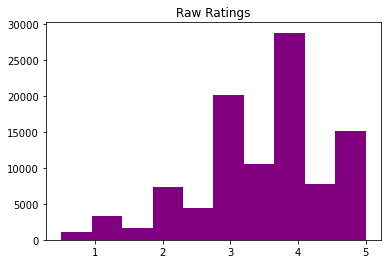

In [3]:
plt.hist(ratings_raw["rating"], color="purple", bins=10)
plt.title("Raw Ratings")
plt.show()

In [4]:
movies = set(ratings_raw["movieId"].unique())
avgs = []
stdv = []
stds = []
movie_variance = dict()
for movie in movies:
    if len(ratings_raw[ratings_raw["movieId"] == movie]) >= 50:
        avgs.append(ratings_raw[ratings_raw["movieId"] == movie]["rating"].mean())
        stdv.append(ratings_raw[ratings_raw["movieId"] == movie]["rating"].var())
        stds.append(ratings_raw[ratings_raw["movieId"] == movie]["rating"].std())
        movie_variance[movie] = ratings_raw[ratings_raw["movieId"] == movie]["rating"].var()

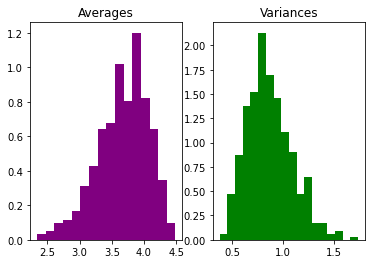

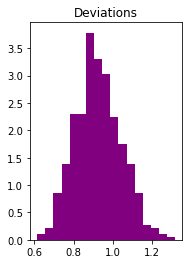

In [5]:
plt.subplot(1, 2, 1)
plt.hist(avgs, density=True, color="purple", bins="auto")
plt.title("Averages")
plt.subplot(1, 2, 2)
plt.hist(stdv, density=True, color="green", bins="auto")
plt.title("Variances")
plt.show()
plt.subplot(1, 2, 1)
plt.hist(stds, density=True, color="purple", bins="auto")
plt.title("Deviations")
plt.show()

#### 1.3. question:

Does the distribution remind you of a known distribution? Is the distribution possibly normal or some other?

Judging by the shape of the graphs, I think that the distribution we're looking at is a Beta Distribution.

#### 1.4. question:

Assess the parameters of this distribution by means of the procedures we have learned at the exercises. From the distributions we have learned at the exercises, choose the one that best fits the data.

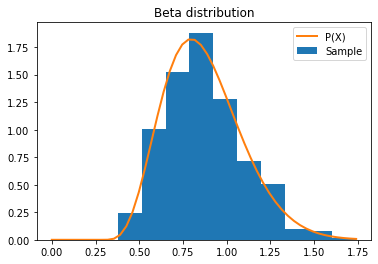

In [6]:
from scipy.stats import beta

data = stdv

x_axis = np.linspace(0, 1)
interval = x_axis * max(data) - min(data) + min(data)

parameters_Beta = beta.fit(data)
P_beta = [beta.pdf(x, *parameters_Beta) for x in interval]

plt.figure()
plt.hist(data,    label="Sample", density=True)
plt.plot(interval, P_beta, label="P(X)", linewidth=2.0)
plt.title("Beta distribution")
plt.legend();

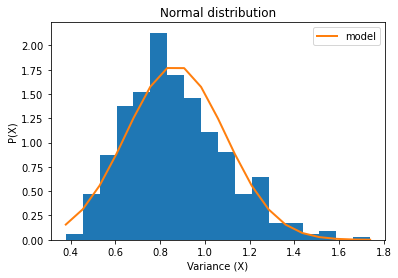

In [7]:
from scipy.stats import multivariate_normal as mvn

n = len(data)
mu = np.mean(data)             
sigma2 = (n-1)/n * np.var(data)

plt.figure()
counts, bins, _ = plt.hist(data, density=True, bins="auto")
pdf = [mvn.pdf(x, mu, sigma2) for x in bins]                       
plt.plot(bins, pdf, "-", label="model", linewidth=2.0)
plt.xlabel("Variance (X)")
plt.ylabel("P(X)")
plt.title("Normal distribution")
plt.legend();

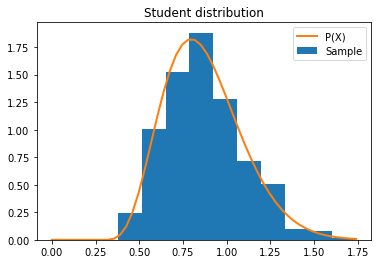

In [8]:
from scipy.stats import t as student 

parameters_Student = student.fit(data)
P_student = [student.pdf(x, *parameters_Student) for x in interval]

plt.figure()
plt.hist(data,    label="Sample", density=True)
plt.plot(interval, P_beta, label="P(X)", linewidth=2.0)
plt.title("Student distribution")
plt.legend();

#### 1.5. question:

Print movies with the value of a random variable that falls in the top 5% of the statistically significant cases.

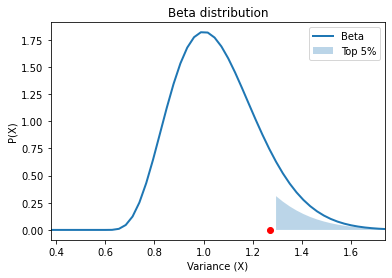

In [9]:
xr    = np.linspace(min(data), max(data))
plt.plot(xr, P_beta, "-", label="Beta", linewidth=2.0)
plt.xlim(min(data), max(data))

border = beta.ppf(0.95, *parameters_Beta) #Percent point function = The probability of an event equal to or less than a given value is defined by the cumulative distribution function
plt.plot(border, 0, "ro")
interval = xr[xr > border]
P_interval = [beta.pdf(x, *parameters_Beta) for x in interval]

plt.fill_between(interval, 0, P_interval, alpha=0.3, label="Top 5%")
plt.title("Beta distribution")
plt.xlabel("Variance (X)")
plt.ylabel("P(X)")
plt.legend(loc=1);

In [10]:
top_five = [(movieId, variance) for (movieId, variance) in movie_variance.items() if variance >= border]

for movie in top_five:
    print("ID:", movie[0], movieNames[movie[0]], ":", movie[1])

ID: 3 Grumpier Old Men (1995) : 1.3227644652250148
ID: 231 Dumb & Dumber (Dumb and Dumber) (1994) : 1.3204567443360475
ID: 673 Space Jam (1996) : 1.5383673469387757
ID: 1183 English Patient, The (1996) : 1.3902721214365044
ID: 1358 Sling Blade (1996) : 1.3907342657342665
ID: 1676 Starship Troopers (1997) : 1.384780907668231
ID: 1721 Titanic (1997) : 1.519255947927577
ID: 1917 Armageddon (1998) : 1.3953460809102405
ID: 2541 Cruel Intentions (1999) : 1.4784313725490192
ID: 2628 Star Wars: Episode I - The Phantom Menace (1999) : 1.3085396170527879
ID: 2657 Rocky Horror Picture Show, The (1975) : 1.3238607270865337
ID: 2700 South Park: Bigger, Longer and Uncut (1999) : 1.4324324324324325
ID: 2710 Blair Witch Project, The (1999) : 1.7395690834473314
ID: 3535 American Psycho (2000) : 1.3637254901960785
ID: 3552 Caddyshack (1980) : 1.2774283717679946
ID: 3623 Mission: Impossible II (2000) : 1.3021604938271605
ID: 4308 Moulin Rouge (2001) : 1.4856902356902353
ID: 4370 A.I. Artificial Intellige

Answer: **You can write the answer in multiple cells**

#### 2. Clustering films (50%)

Recommendation systems often detect groups of objects (in our example films), which are of high similarity.

Find the 100 most watched movies. Are there groups among them?
Use the appropriate clustering algorithm. We can watch the film as a vector where the
number of components is equal to the number of users.

Vectors also contain *unknown values*.
An example of the vectors for ten films is shown in the table below.

Clustering algorithms can be performed in the original space (the coordinate system films-users), or we can compare the films with the similarities we have learned on the exercises.
Think about which method is more appropriate in terms of the data format.

| x          |Movie                                      | $u_0$ |$u_1$ | $u_2$ | $\cdots$ |
|------------|-------------------------------------------|:-----:|:----:|:------|:--------:|
|$\vec{x_0}$ | Fight Club (1999)                         | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_1}$ | Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | ?     | ?    | 2.5   | $\cdots$ |
|$\vec{x_2}$ | Independence Day (a.k.a. ID4) (1996)      | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_3}$ | Dances with  Wolves (1990)                | 4.0   | ?    | ?     | $\cdots$ |
|$\vec{x_4}$ | Fargo (1996)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_5}$ | Speed (1994)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_6}$ | Apollo 13 (1995)                          | ?     | 2.0  | ?     | $\cdots$ |
|$\vec{x_7}$ | Seven (a.k.a. Se7en) (1995)               | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_8}$ | Sixth Sense, The (1999)                   | 3.0   | ?    | 4.0   | $\cdots$ |
|$\vec{x_9}$ | Aladdin (1992)                            | ?     | ?    | ?     | $\cdots$ |
|$\cdots$    | $\cdots$                                  | $\cdots$ | $\cdots$  | $\cdots$ | $\cdots$ |

In doing so, answer the following questions.

#### 2.1. question:

Justify the choice of algorithm and similarity measures.

Initially we organize the data by finding the 100 most watched movies (ID and name). Since we don't know how many clusters there are, we rule out k-means as a vialbe algorithm (it would be too inefficient).

In [11]:
import scipy.cluster.hierarchy as sch

#get number of views for each movie
movies = set(ratings_raw["movieId"].unique())
views = dict()
for movie in movies:
    views[movie] = len(ratings_raw[ratings_raw["movieId"] == movie])

#prepare data and create matrix
views = dict(sorted(views.items(), key=lambda item: item[1]))
mostWatchedMovies = list(views)[-100:]
users = set(ratings_raw["userId"].unique())
matrix = []

for movie in mostWatchedMovies:
    matrixRow = []
    tempDF = ratings_raw[ratings_raw["movieId"] == movie]
    for user in users:
        if tempDF[tempDF["userId"] == user].empty:
            matrixRow.append(-1)
        else:
            matrixRow.append(tempDF[tempDF["userId"] == user]["rating"].item())
    matrix.append(matrixRow)

Let's try out different metric algorithms with different linkages to find the optimal methods/algorithms. I decided to start off with complete linkage.

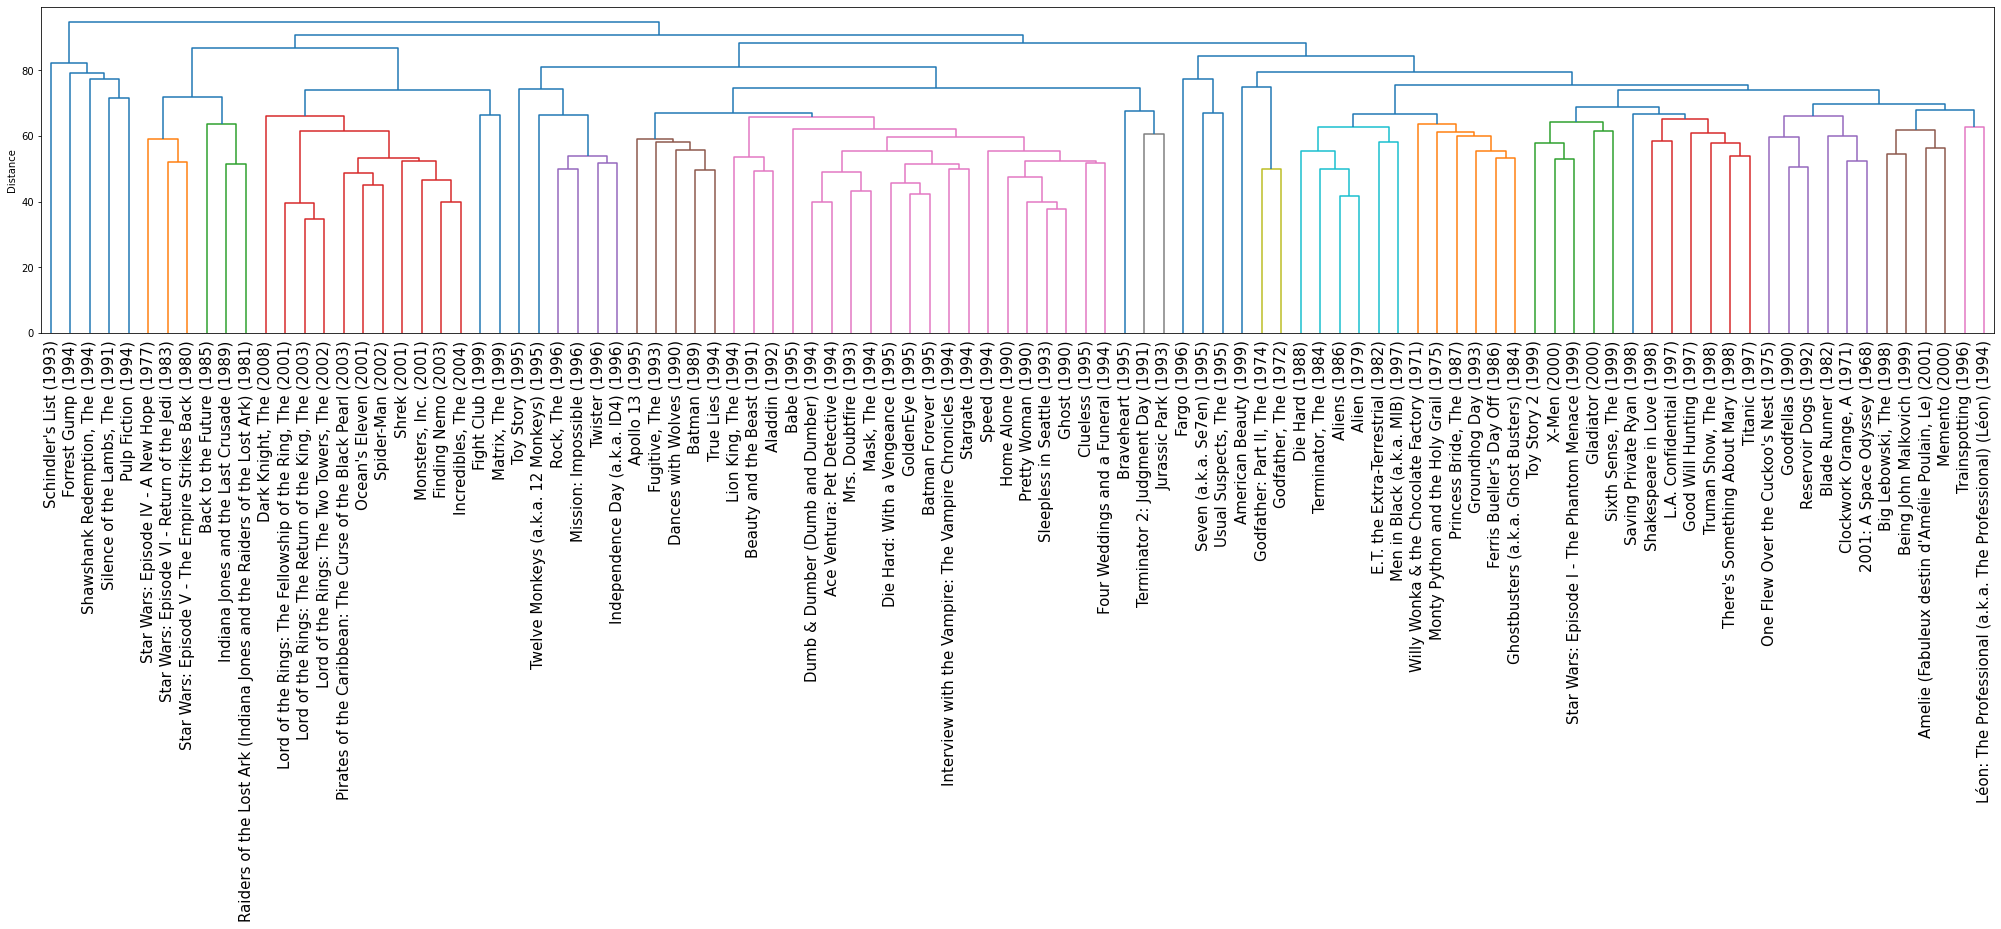

In [12]:
L = sch.linkage(np.array(matrix), method="complete", metric="euclidean")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

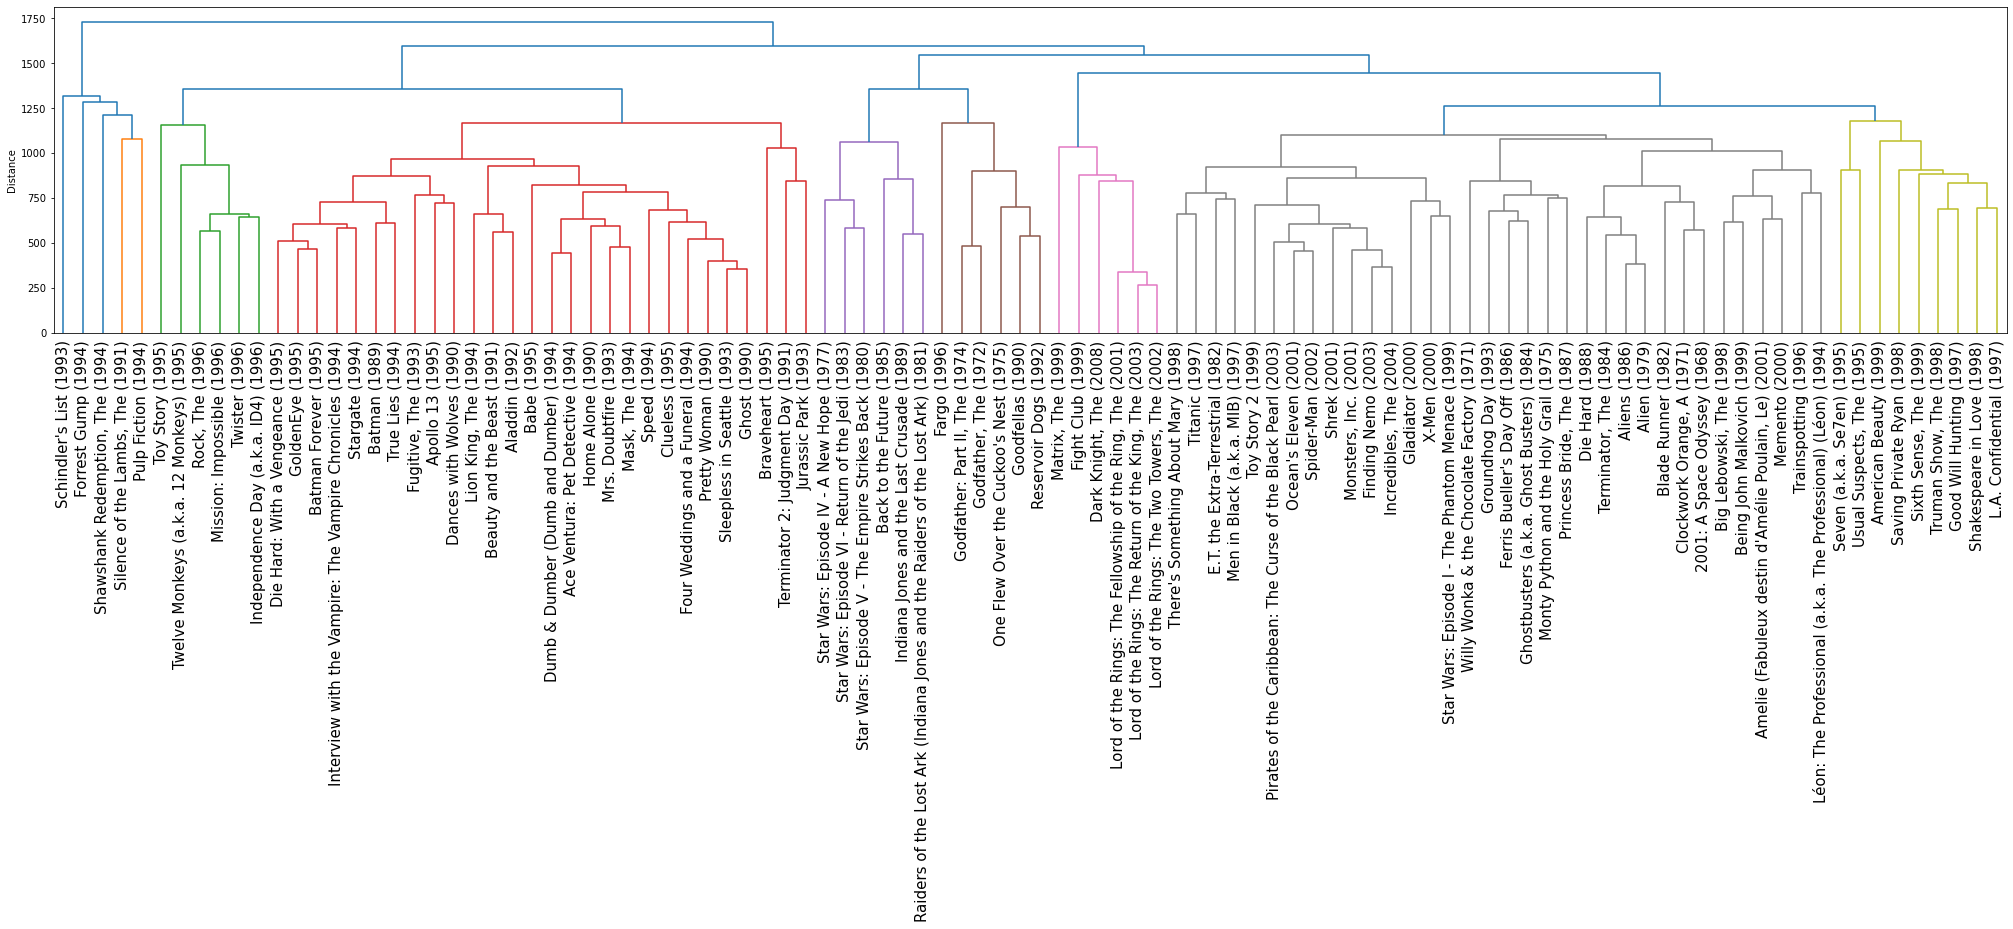

In [13]:
L = sch.linkage(np.array(matrix), method="complete", metric="cityblock")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

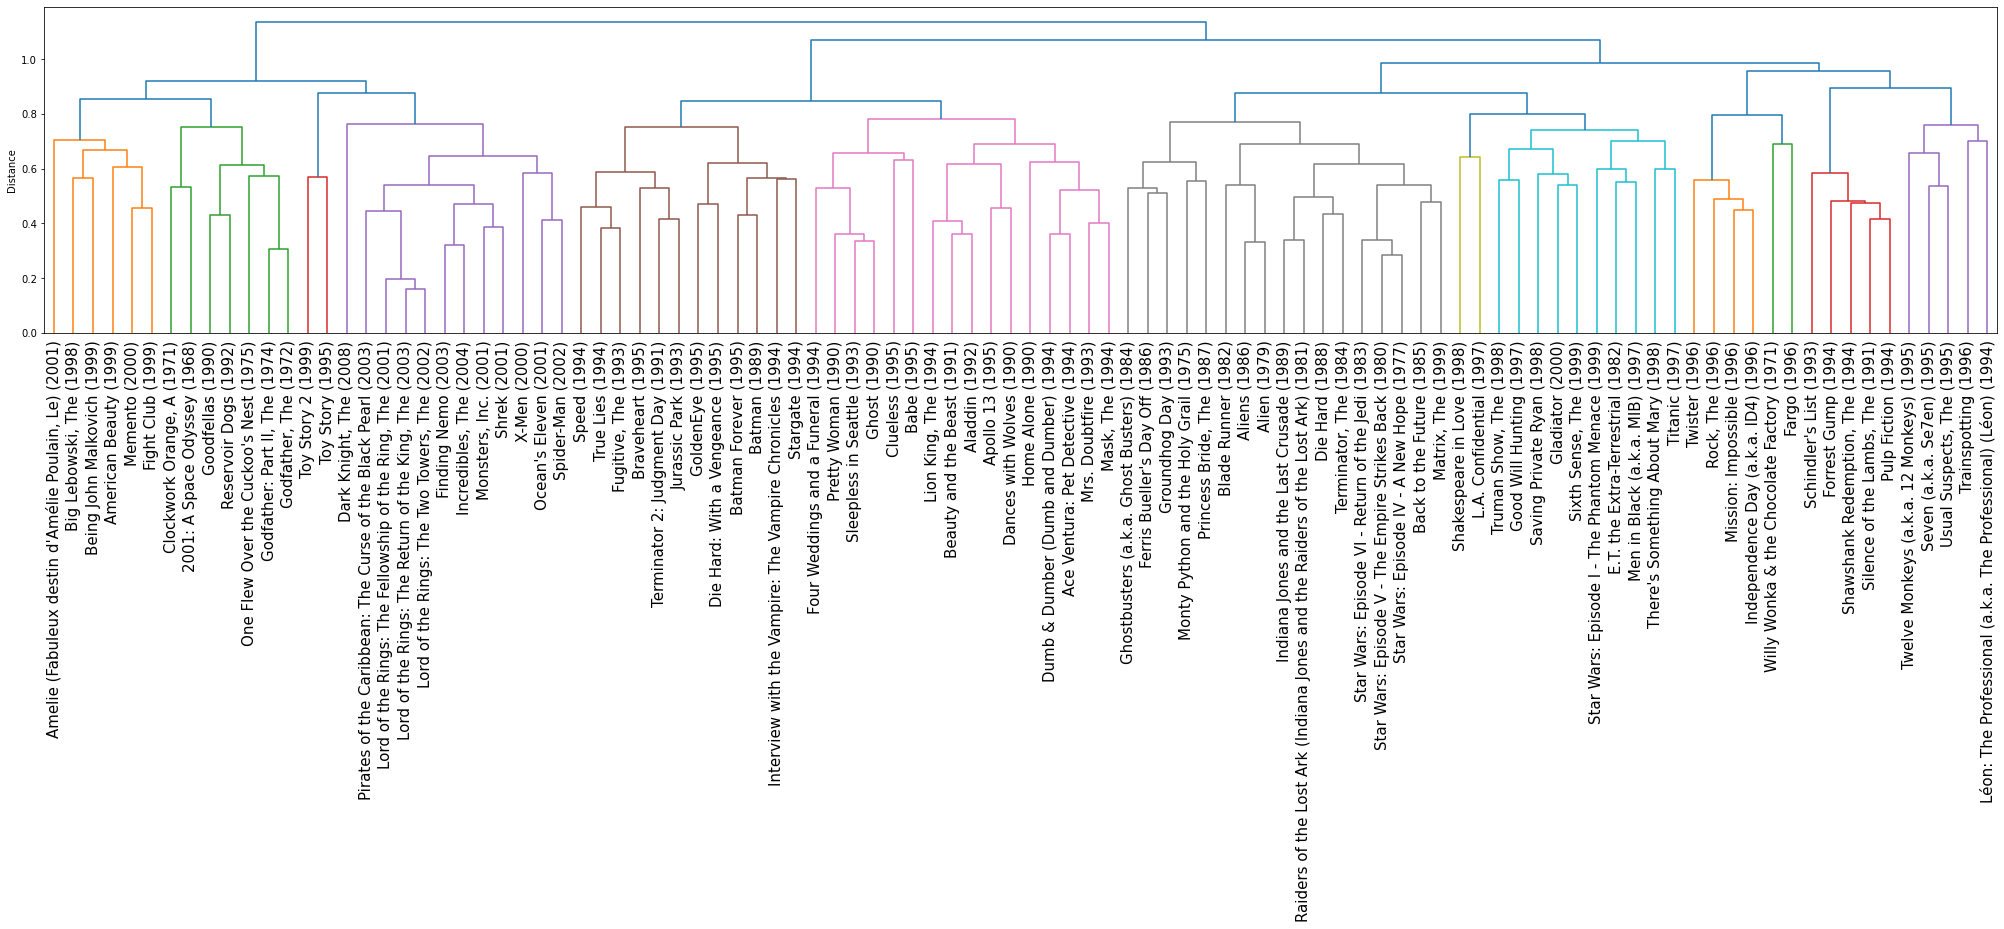

In [14]:
L = sch.linkage(np.array(matrix), method="complete", metric="cosine")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

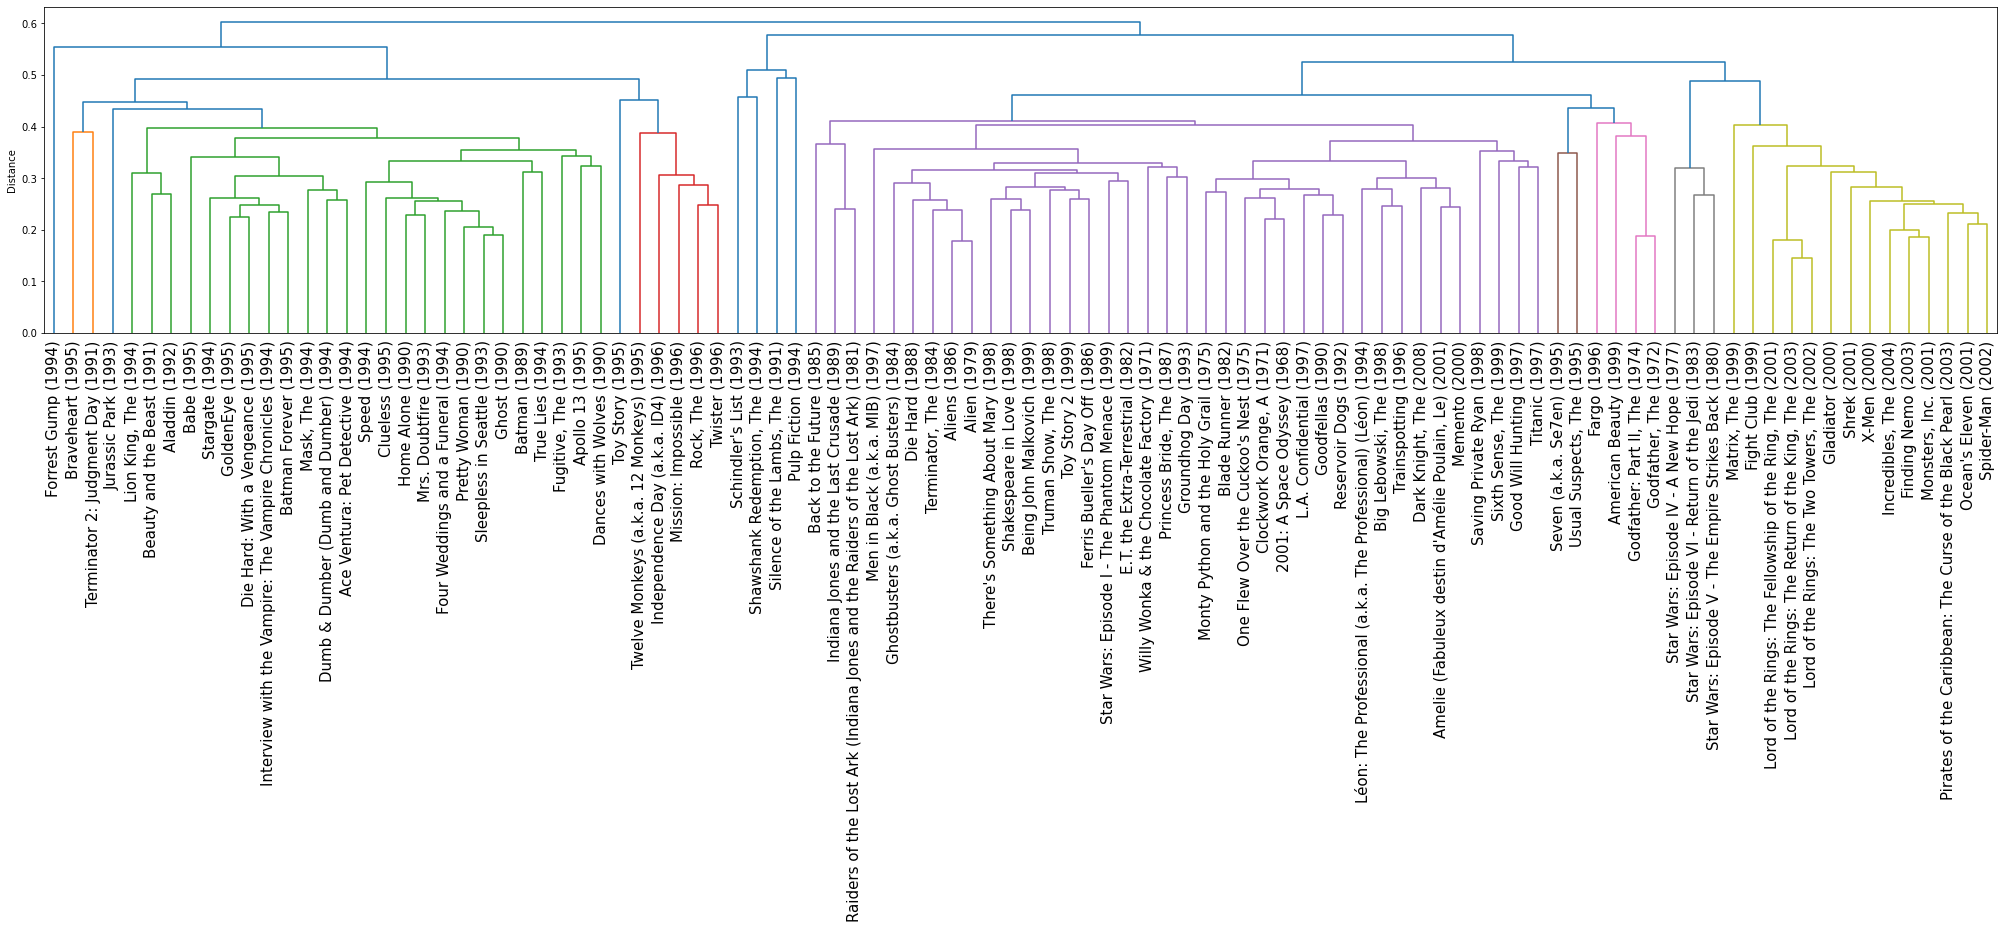

In [15]:
L = sch.linkage(np.array(matrix), method="complete", metric="jaccard")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

Now let's try the different algorithms for single linkage.

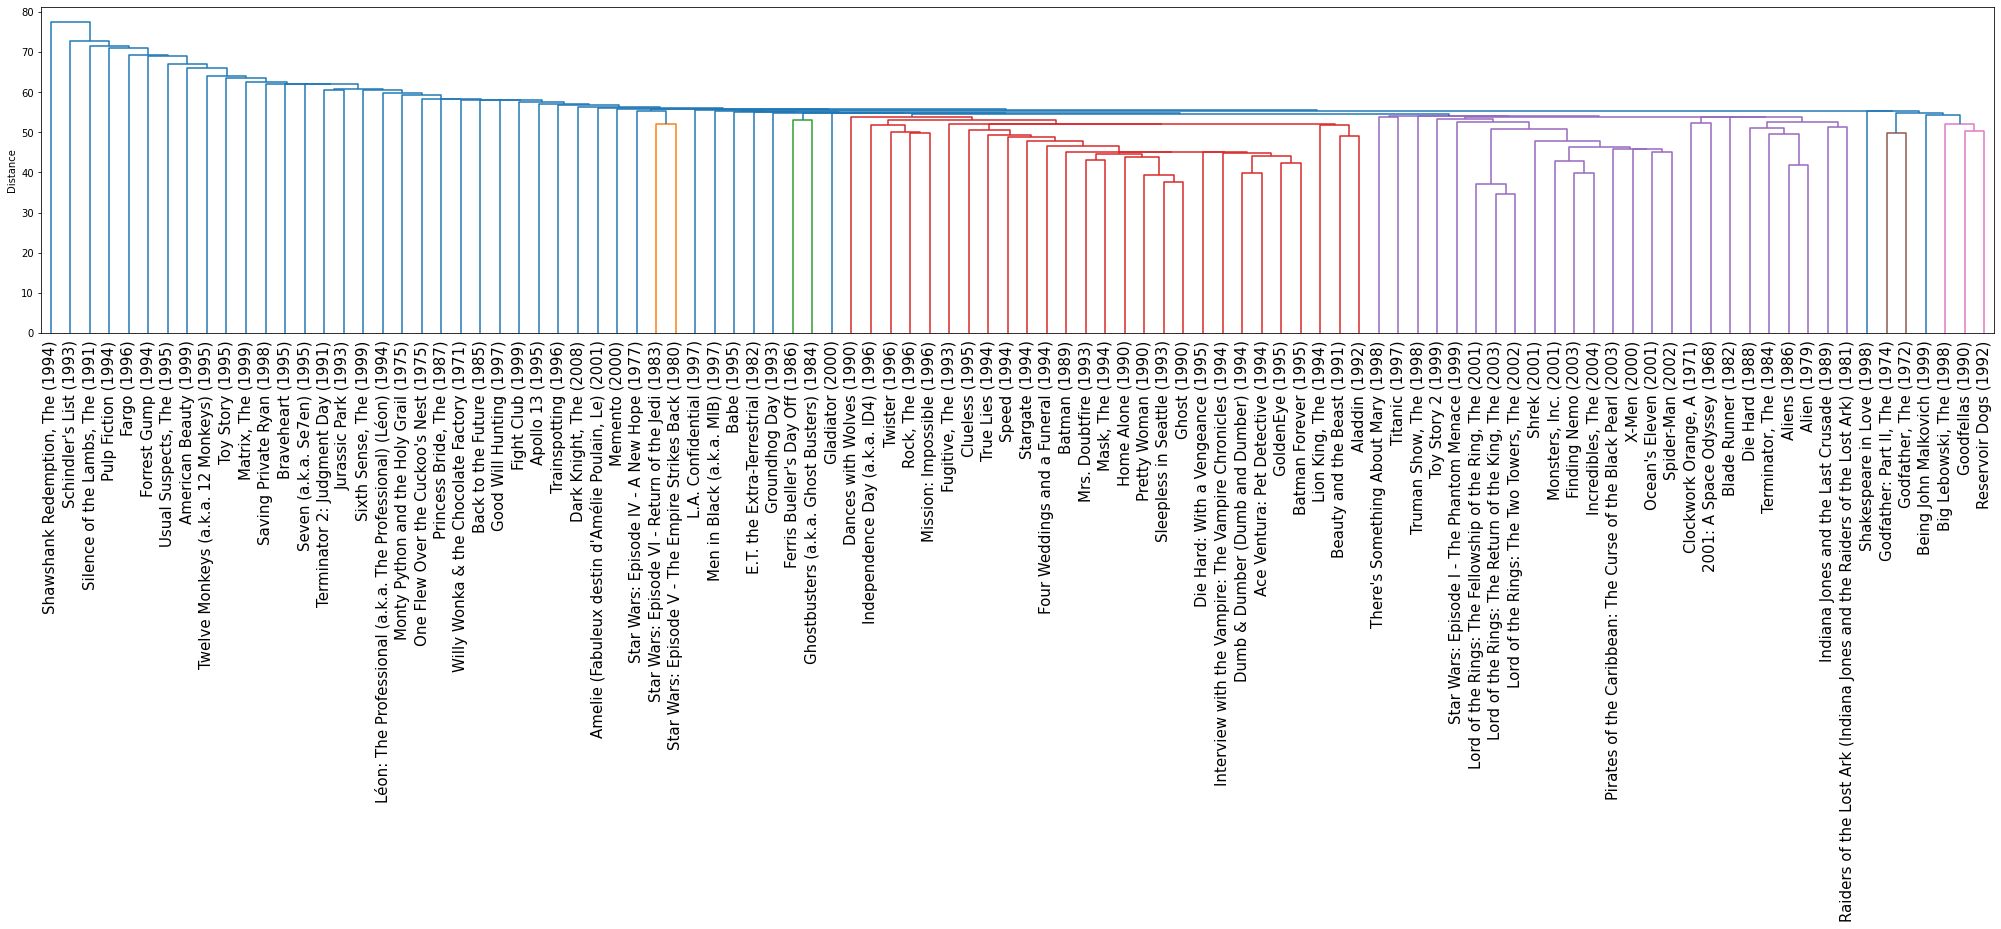

In [16]:
L = sch.linkage(np.array(matrix), method="single", metric="euclidean")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

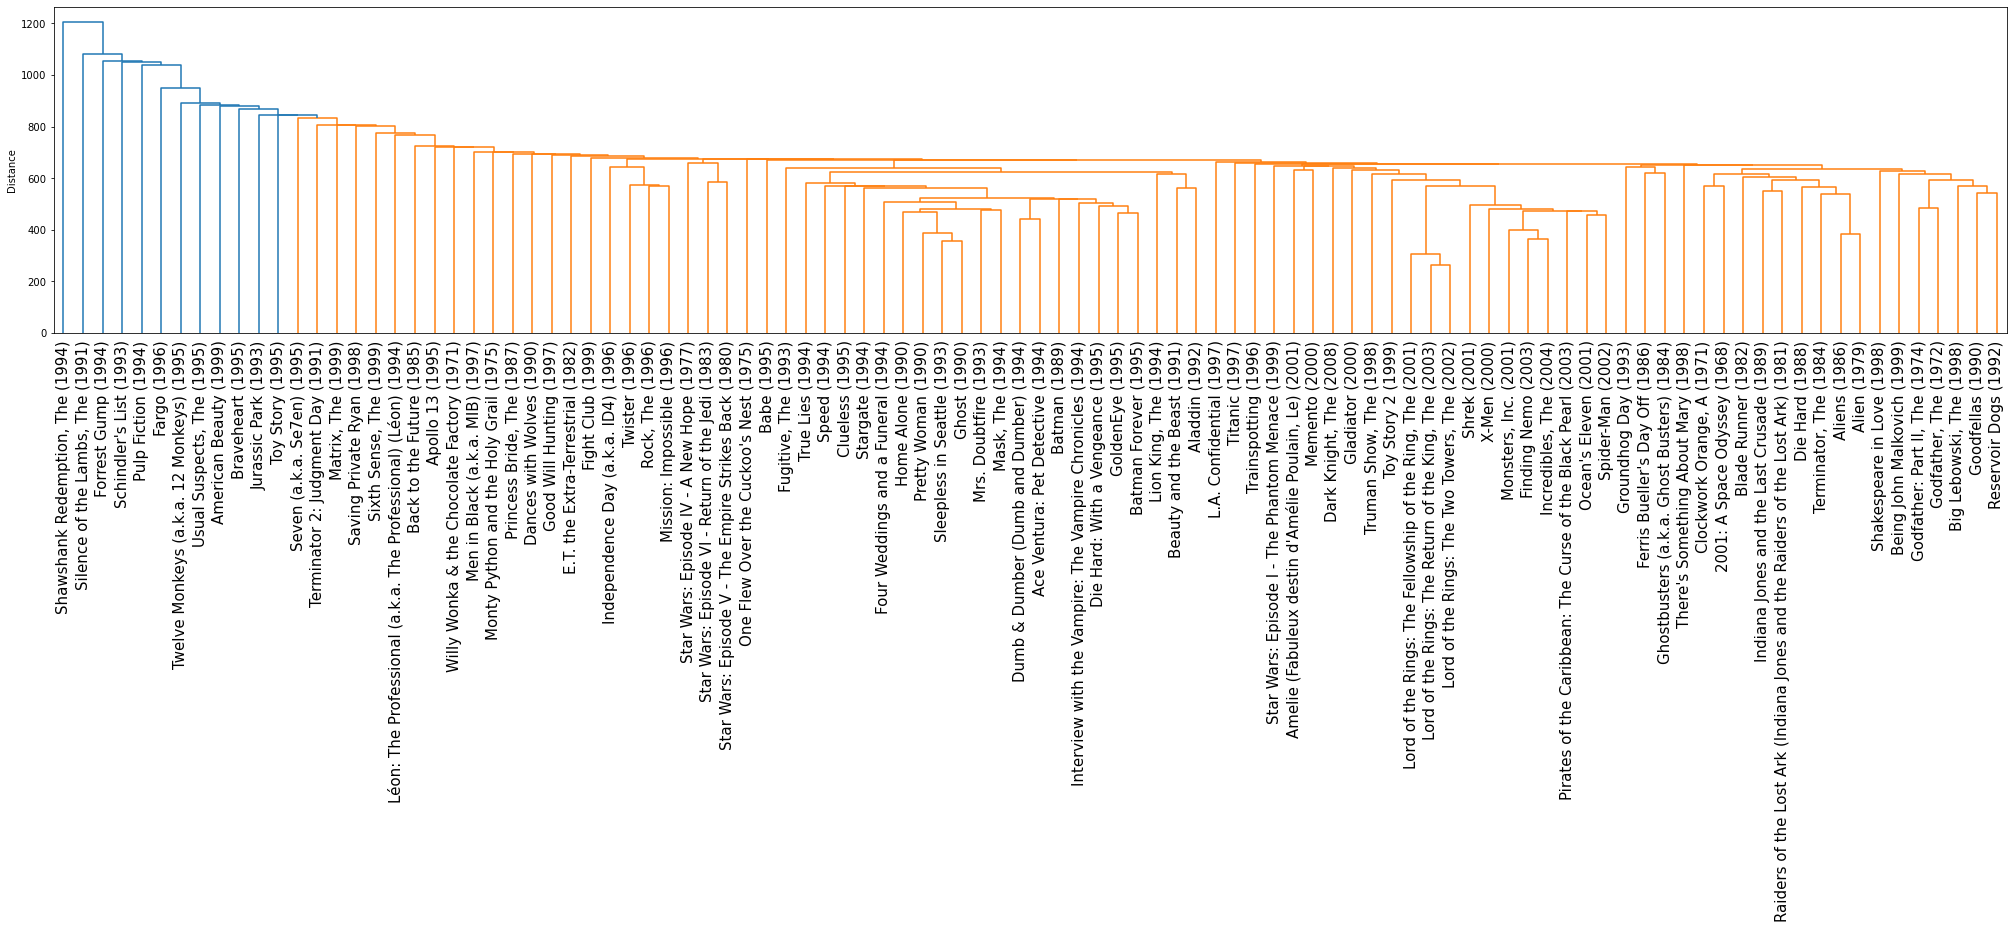

In [17]:
L = sch.linkage(np.array(matrix), method="single", metric="cityblock")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

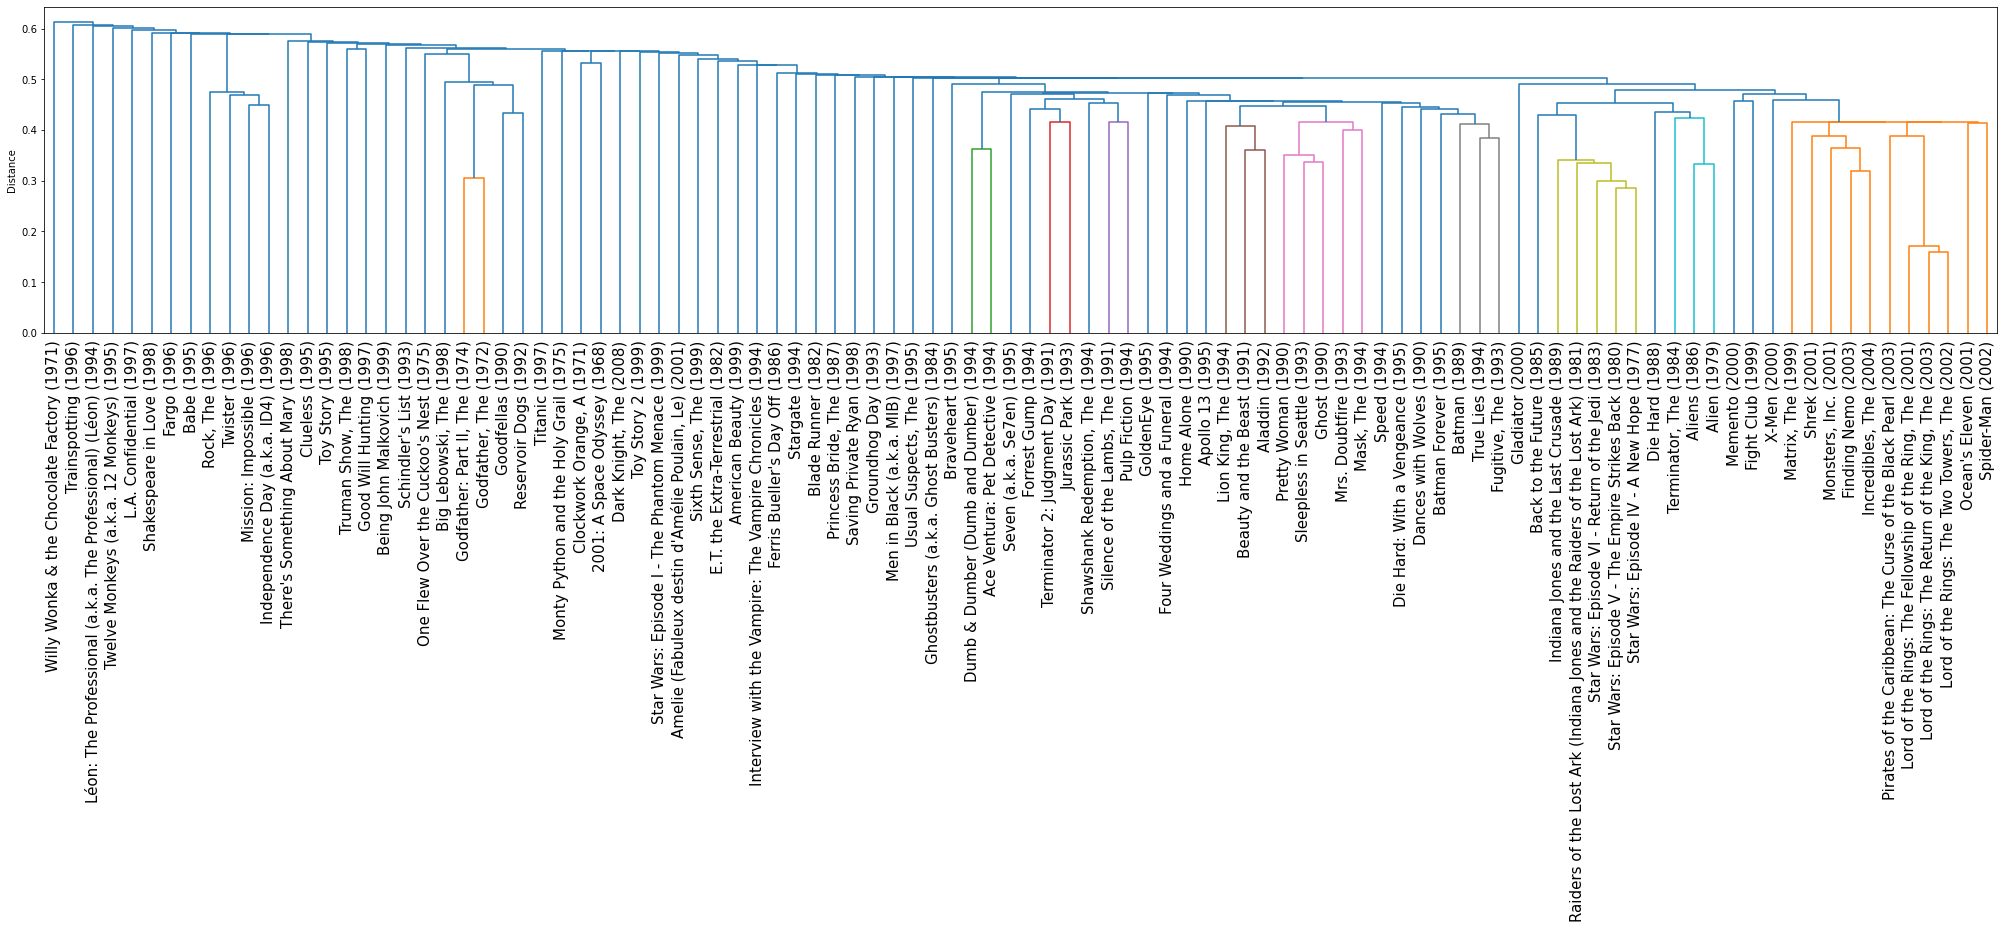

In [18]:
L = sch.linkage(np.array(matrix), method="single", metric="cosine")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

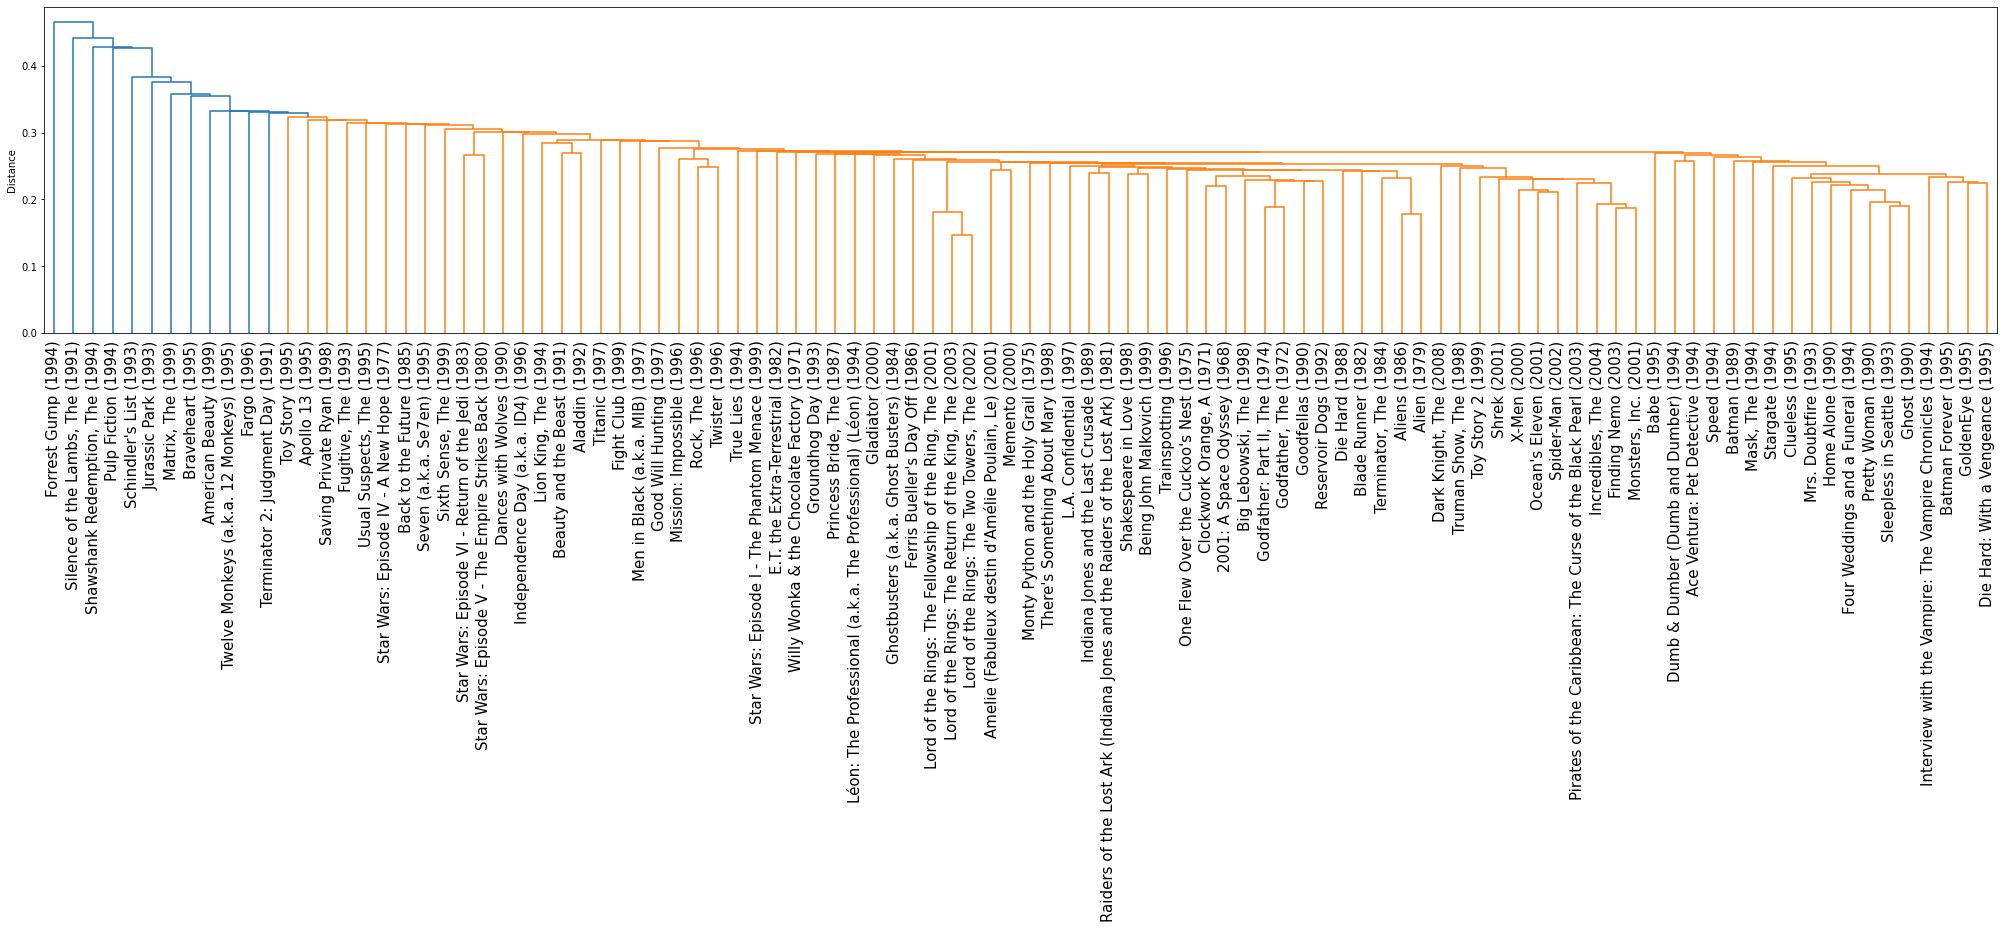

In [19]:
L = sch.linkage(np.array(matrix), method="single", metric="jaccard")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

The results for single linkage look less appealing. Now let's do average linkage.

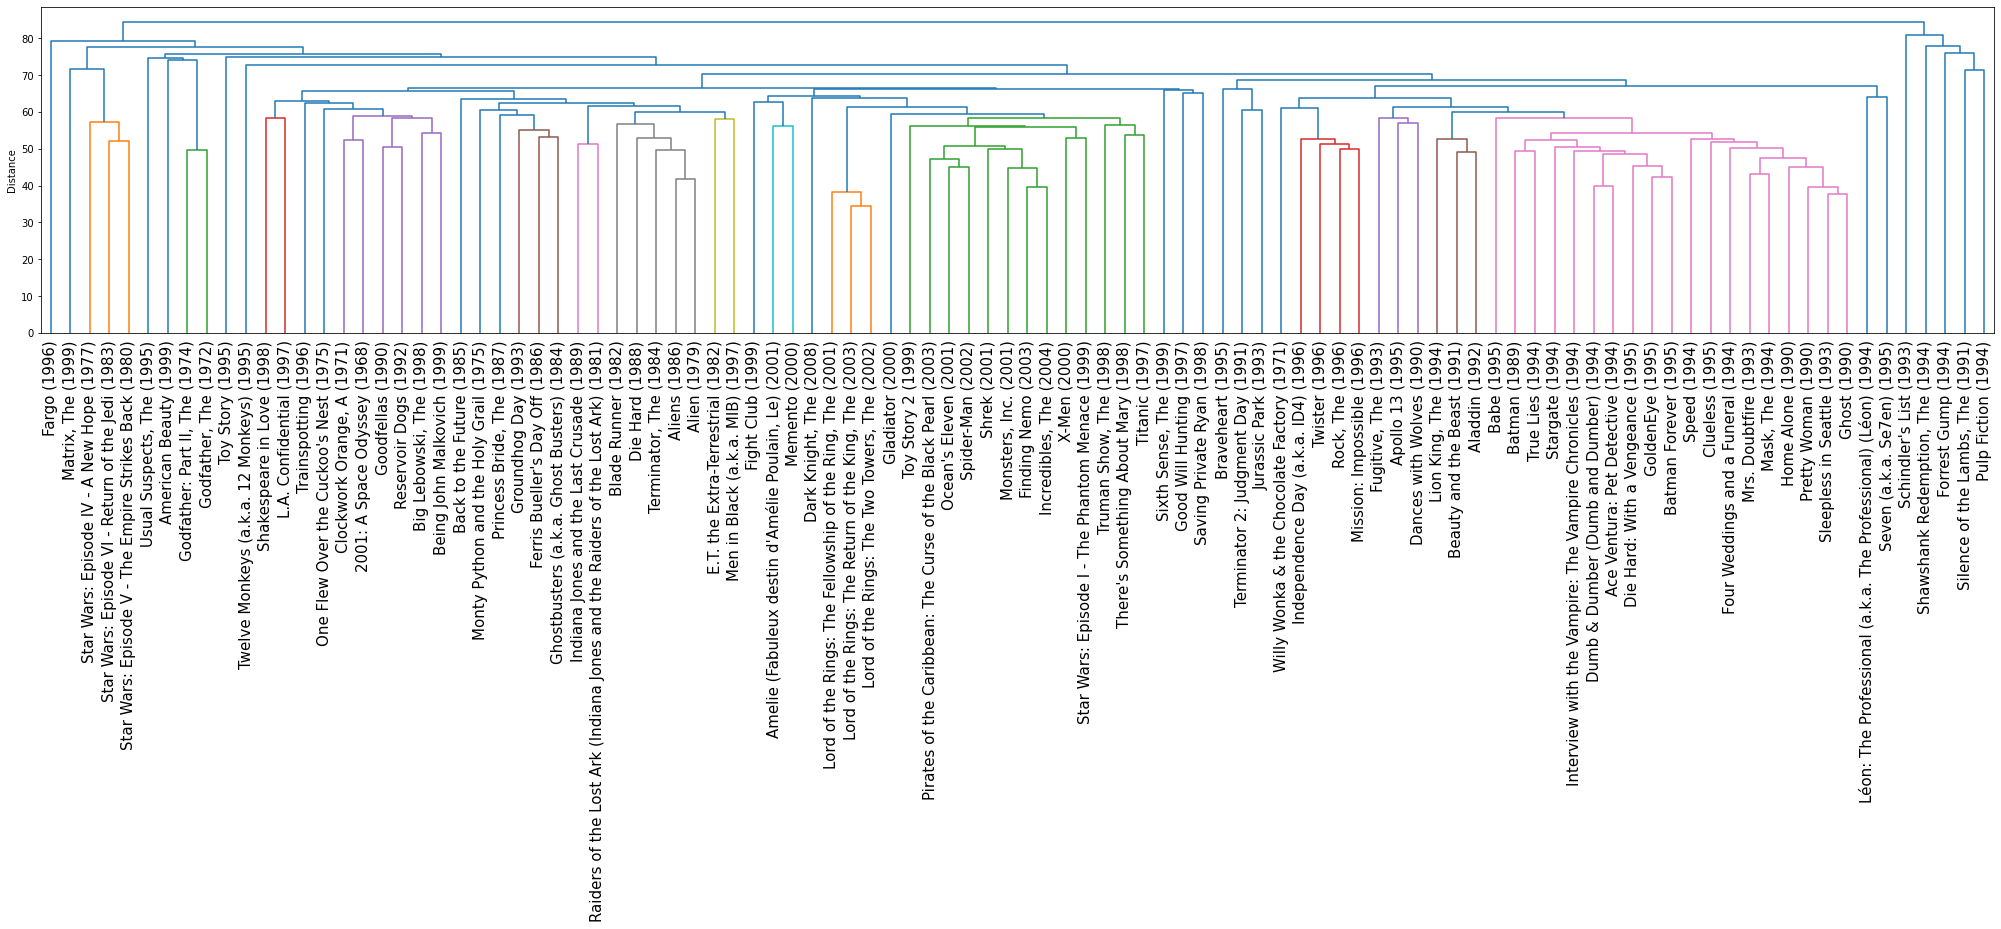

In [20]:
L = sch.linkage(np.array(matrix), method="average", metric="euclidean")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

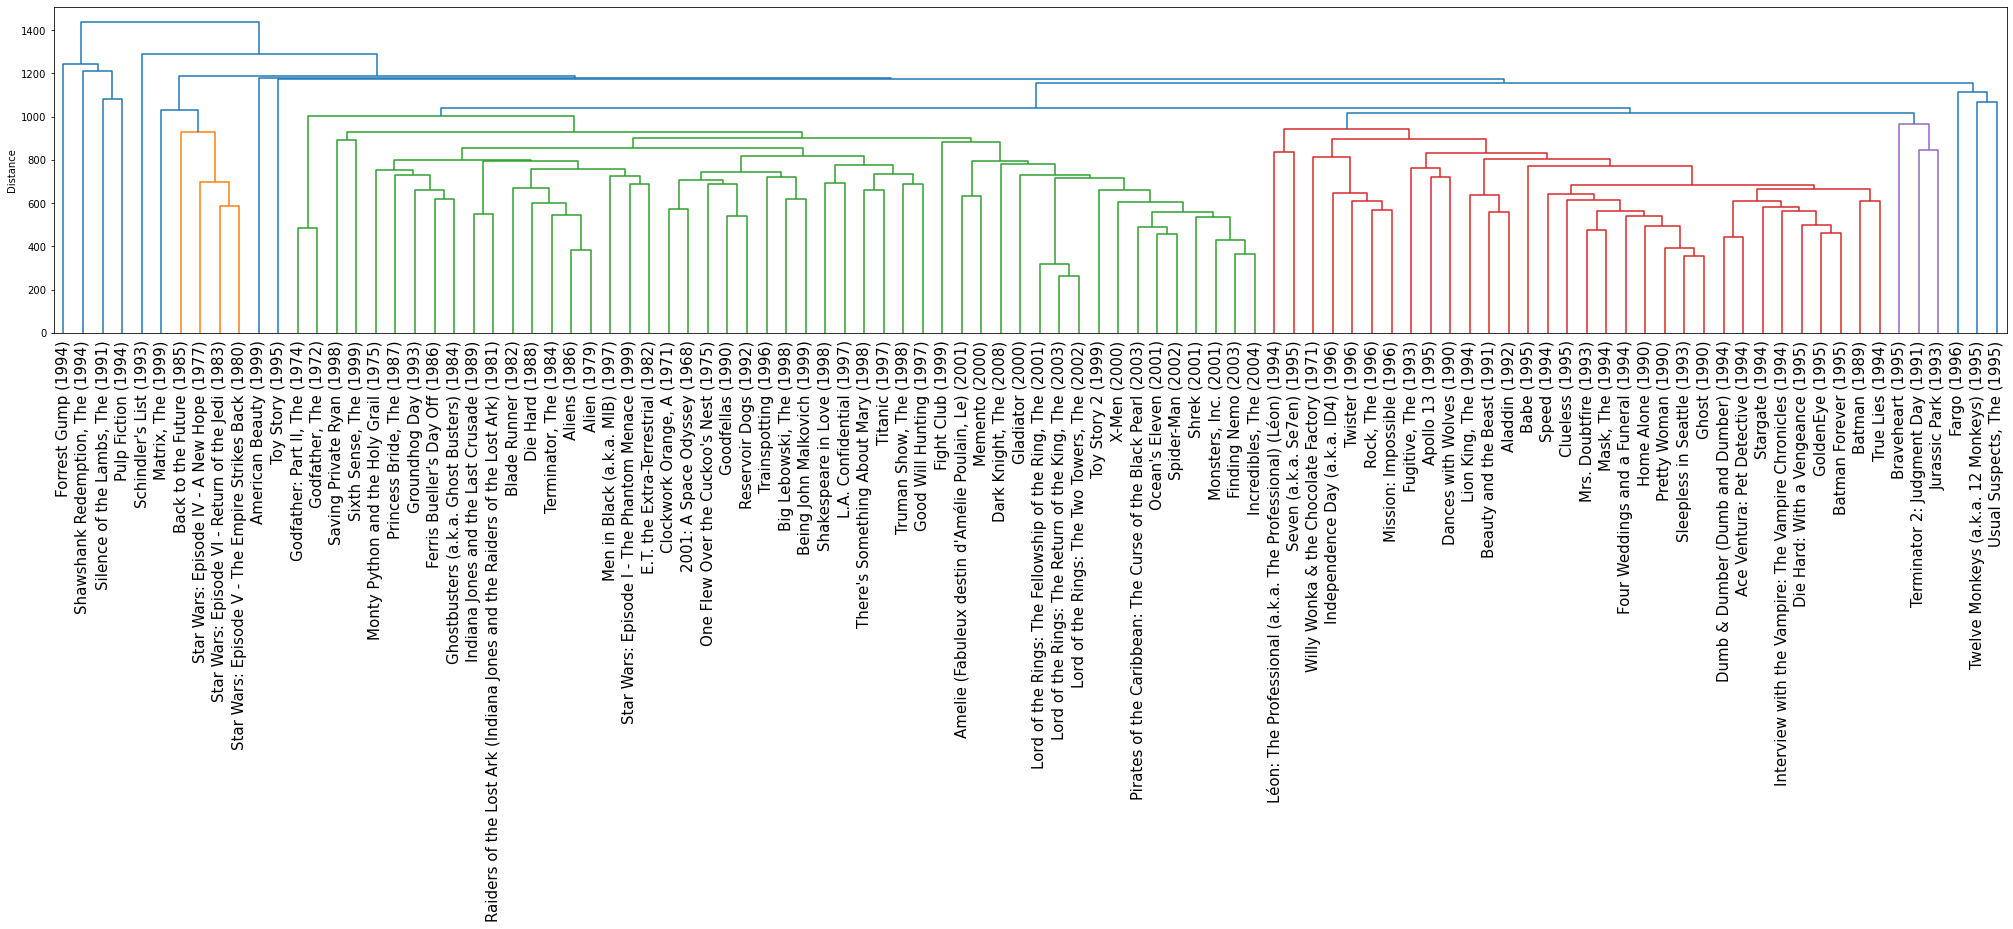

In [21]:
L = sch.linkage(np.array(matrix), method="average", metric="cityblock")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

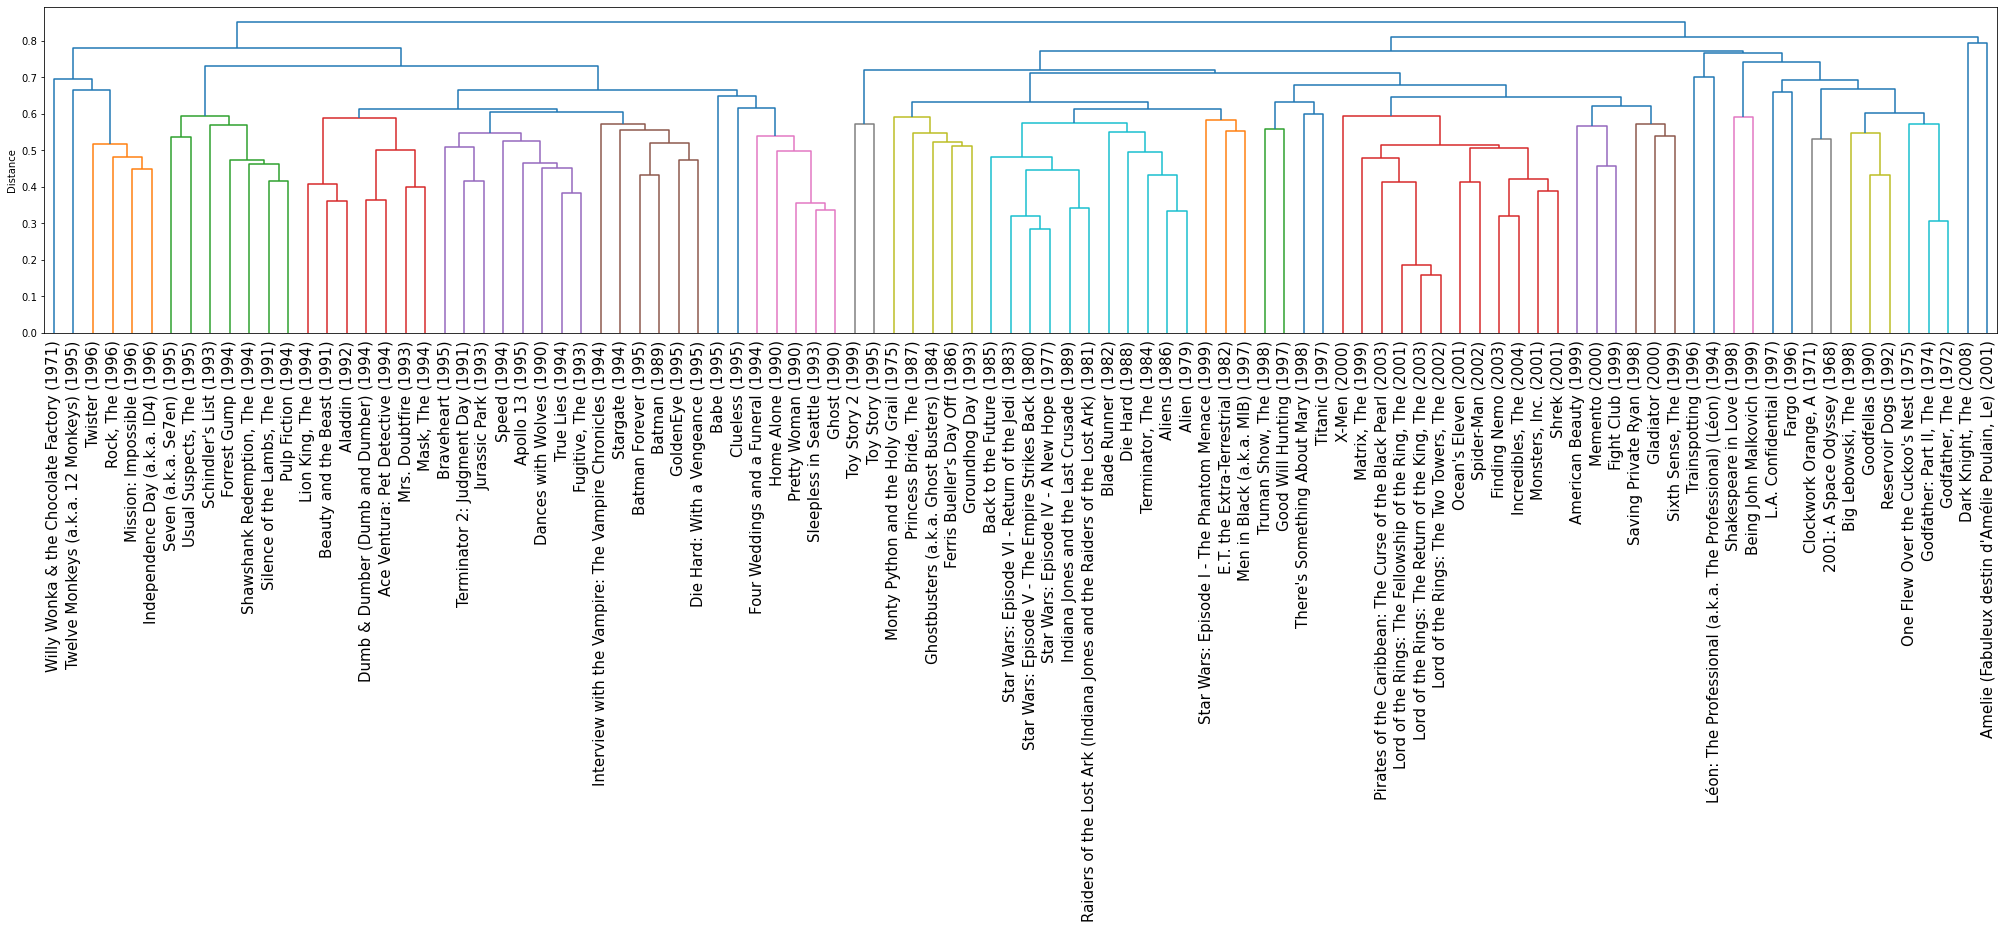

In [22]:
L = sch.linkage(np.array(matrix), method="average", metric="cosine")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

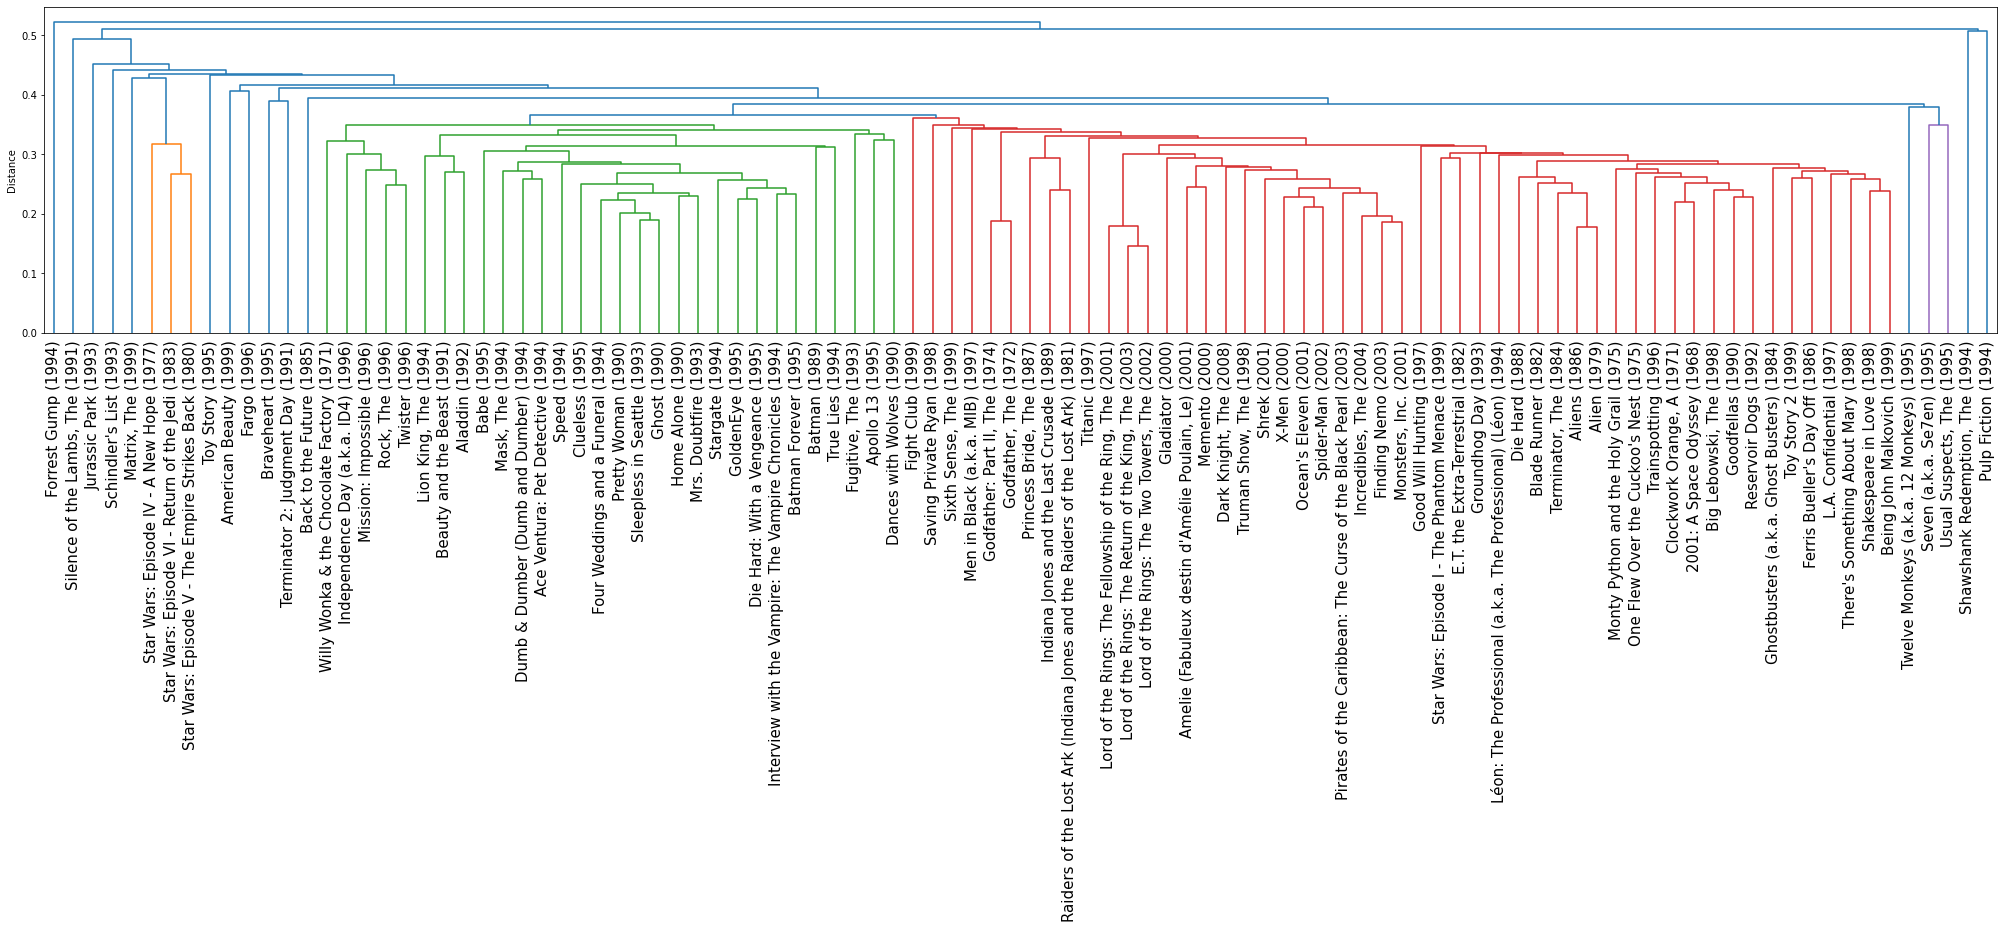

In [23]:
L = sch.linkage(np.array(matrix), method="average", metric="jaccard")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

This looks better than single linkage. Lastly, let's try weighted linkage.

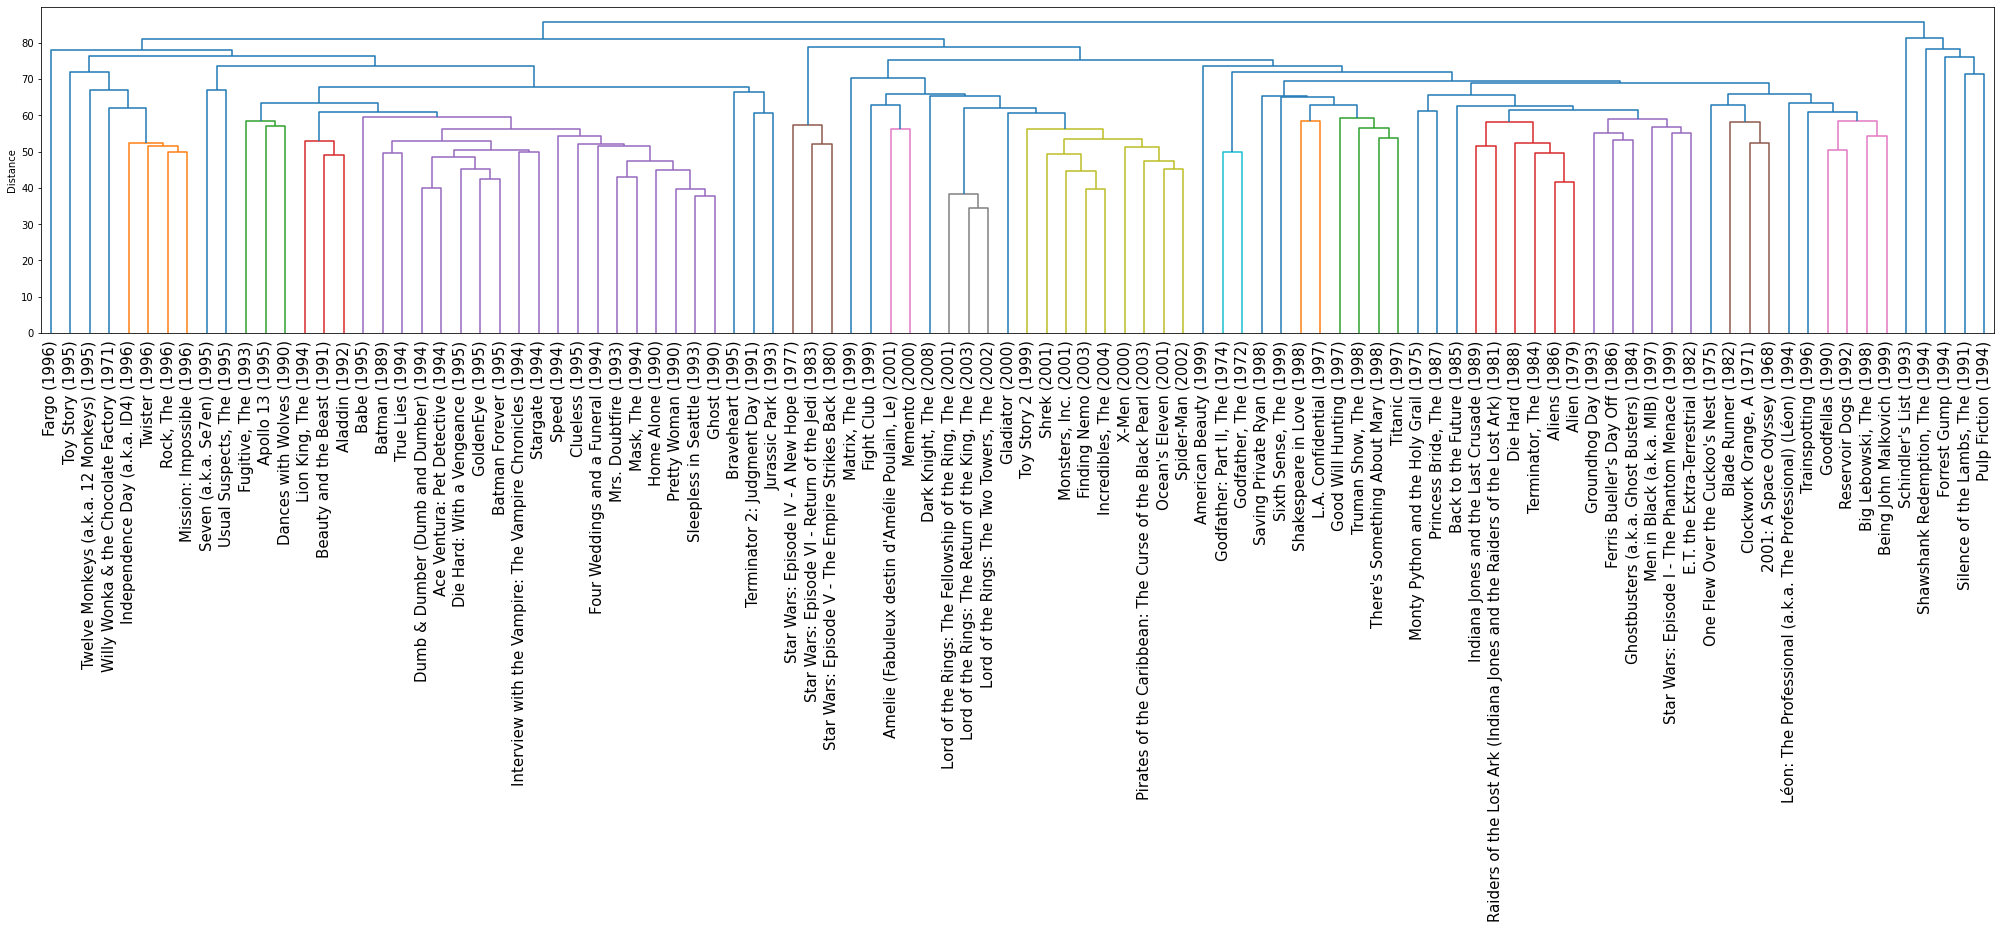

In [24]:
L = sch.linkage(np.array(matrix), method="weighted", metric="euclidean")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

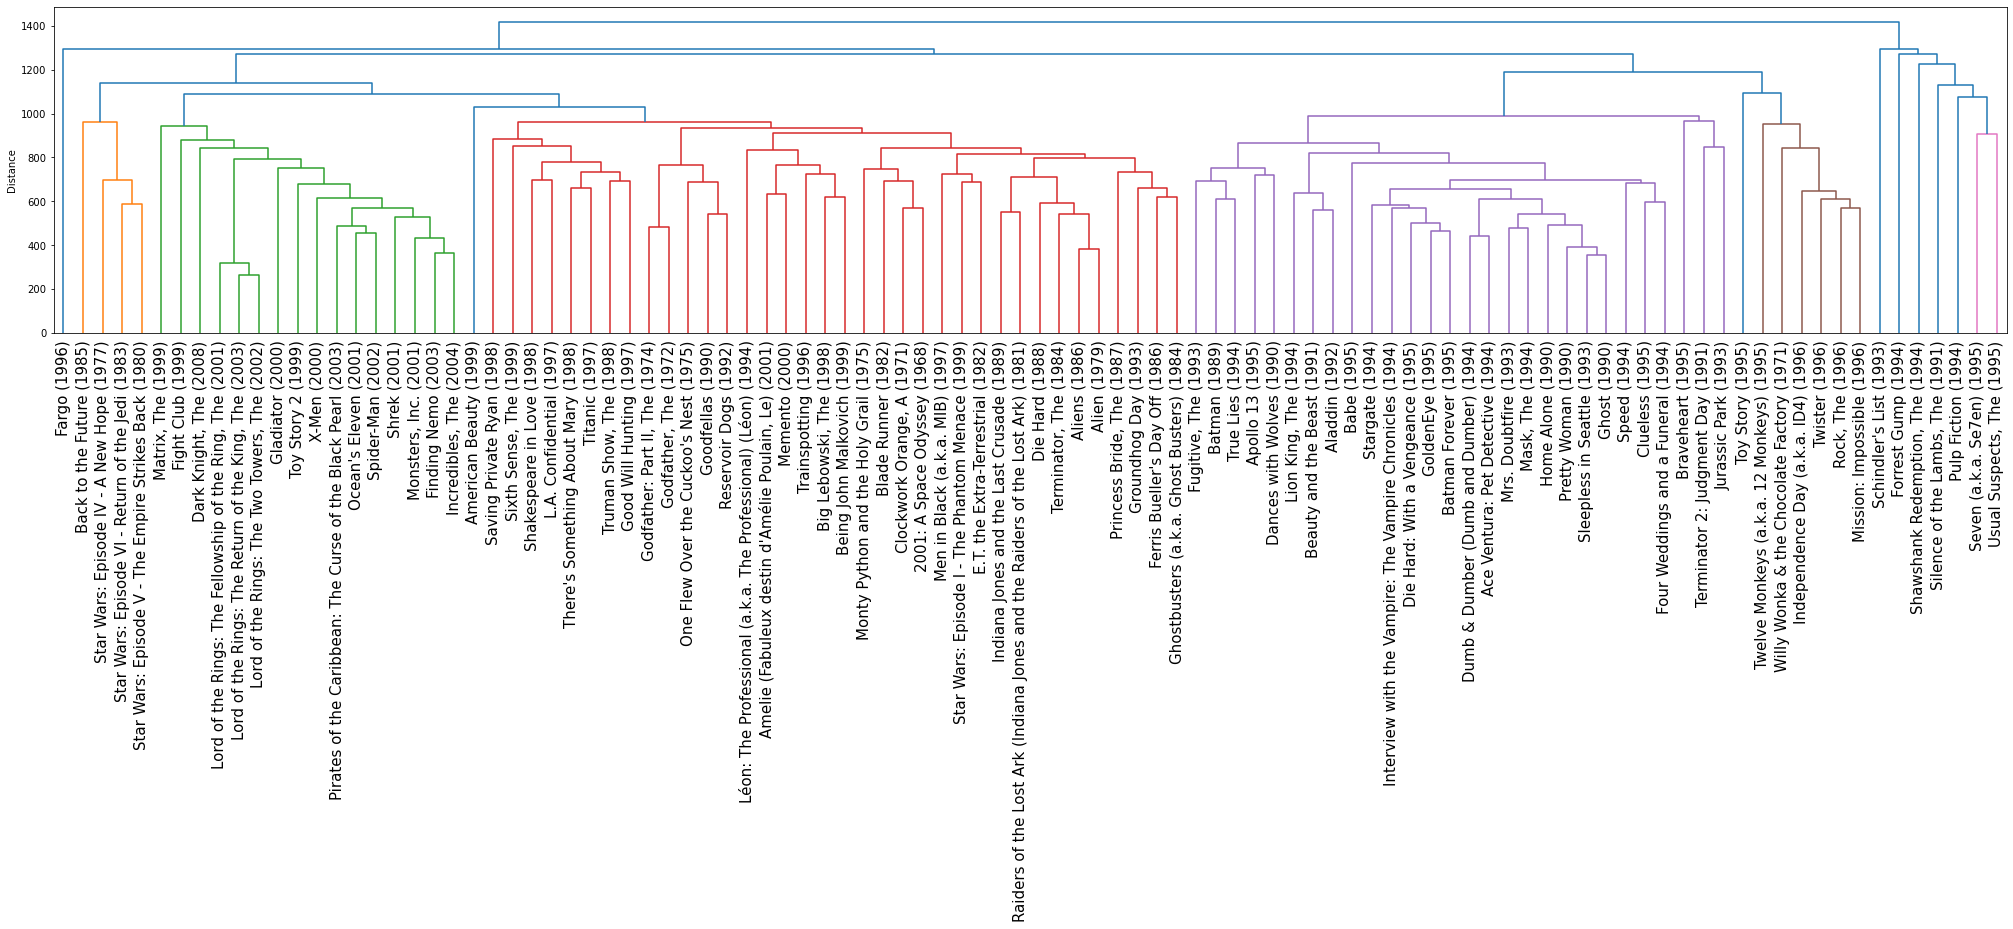

In [25]:
L = sch.linkage(np.array(matrix), method="weighted", metric="cityblock")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

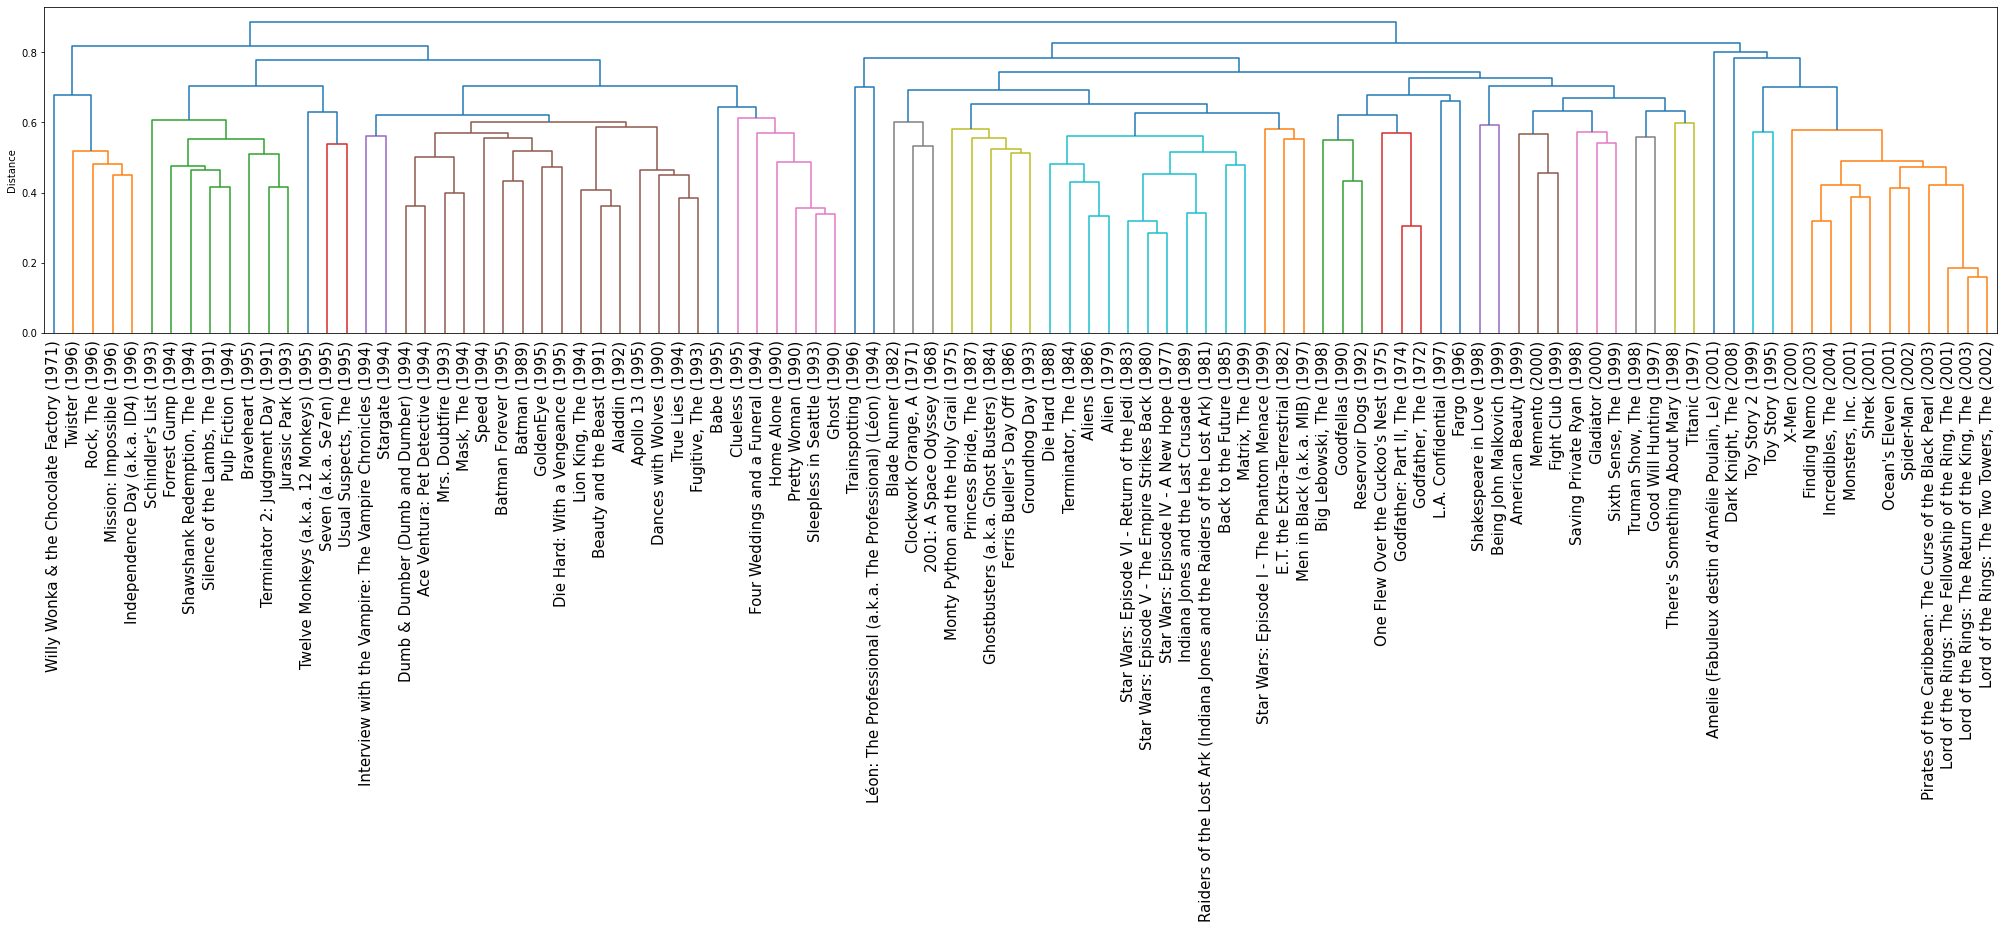

In [26]:
L = sch.linkage(np.array(matrix), method="weighted", metric="cosine")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

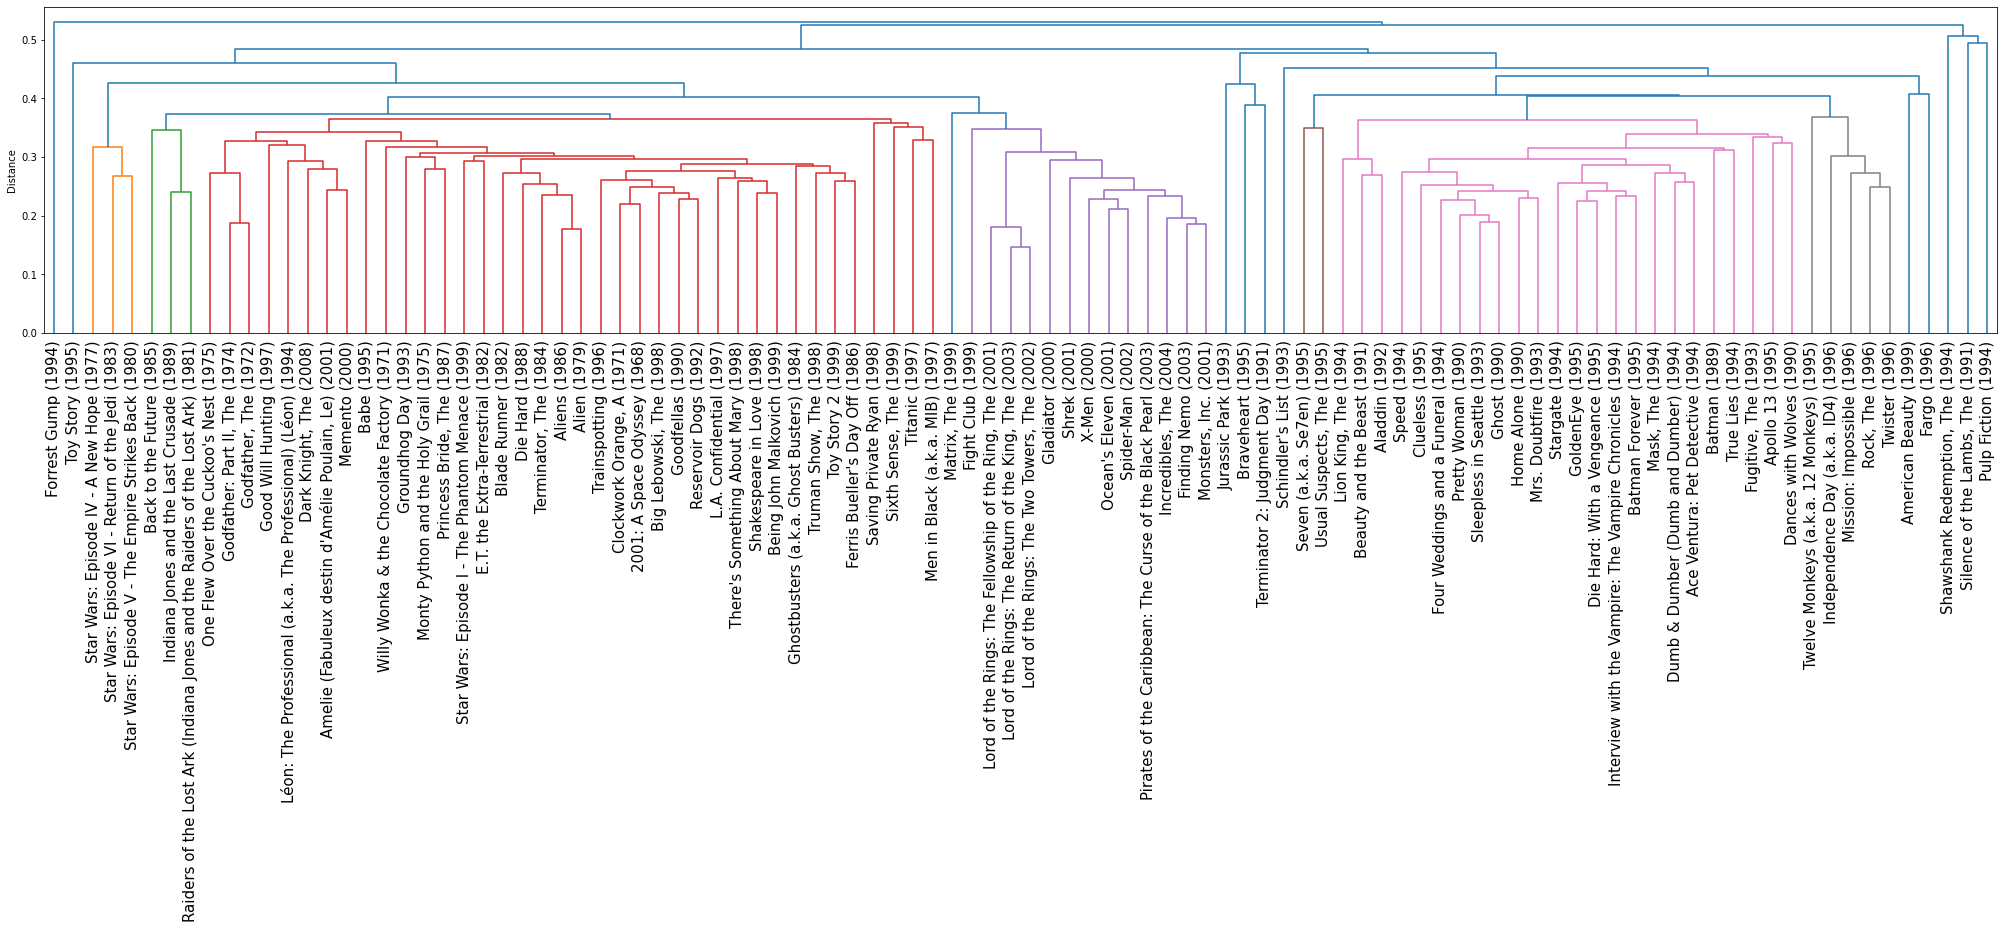

In [27]:
L = sch.linkage(np.array(matrix), method="weighted", metric="jaccard")
plt.figure(figsize=(35, 6))
labels = [movieNames[movie] for movie in mostWatchedMovies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.show()

We choose cosine with complete linkage. I think this is the optimal option just based on the amount of cluters, the distance when the clusters were formed and the contents of the clusters.

#### 2.2. question:

How many groups of films are among the selected? Do we know the quantitative estimates for the various grouping options?

In [33]:
L = sch.linkage(np.array(matrix), method="complete", metric="cosine")

t = 0.85
predictions = sch.fcluster(L, t=t, criterion="distance").ravel()
clusters = np.array(matrix).ravel()
print(len(predictions))

100


Based on the dendogram, 9 clusters have been formed.

#### 2.3. question:

Display results using an appropriate visualization.

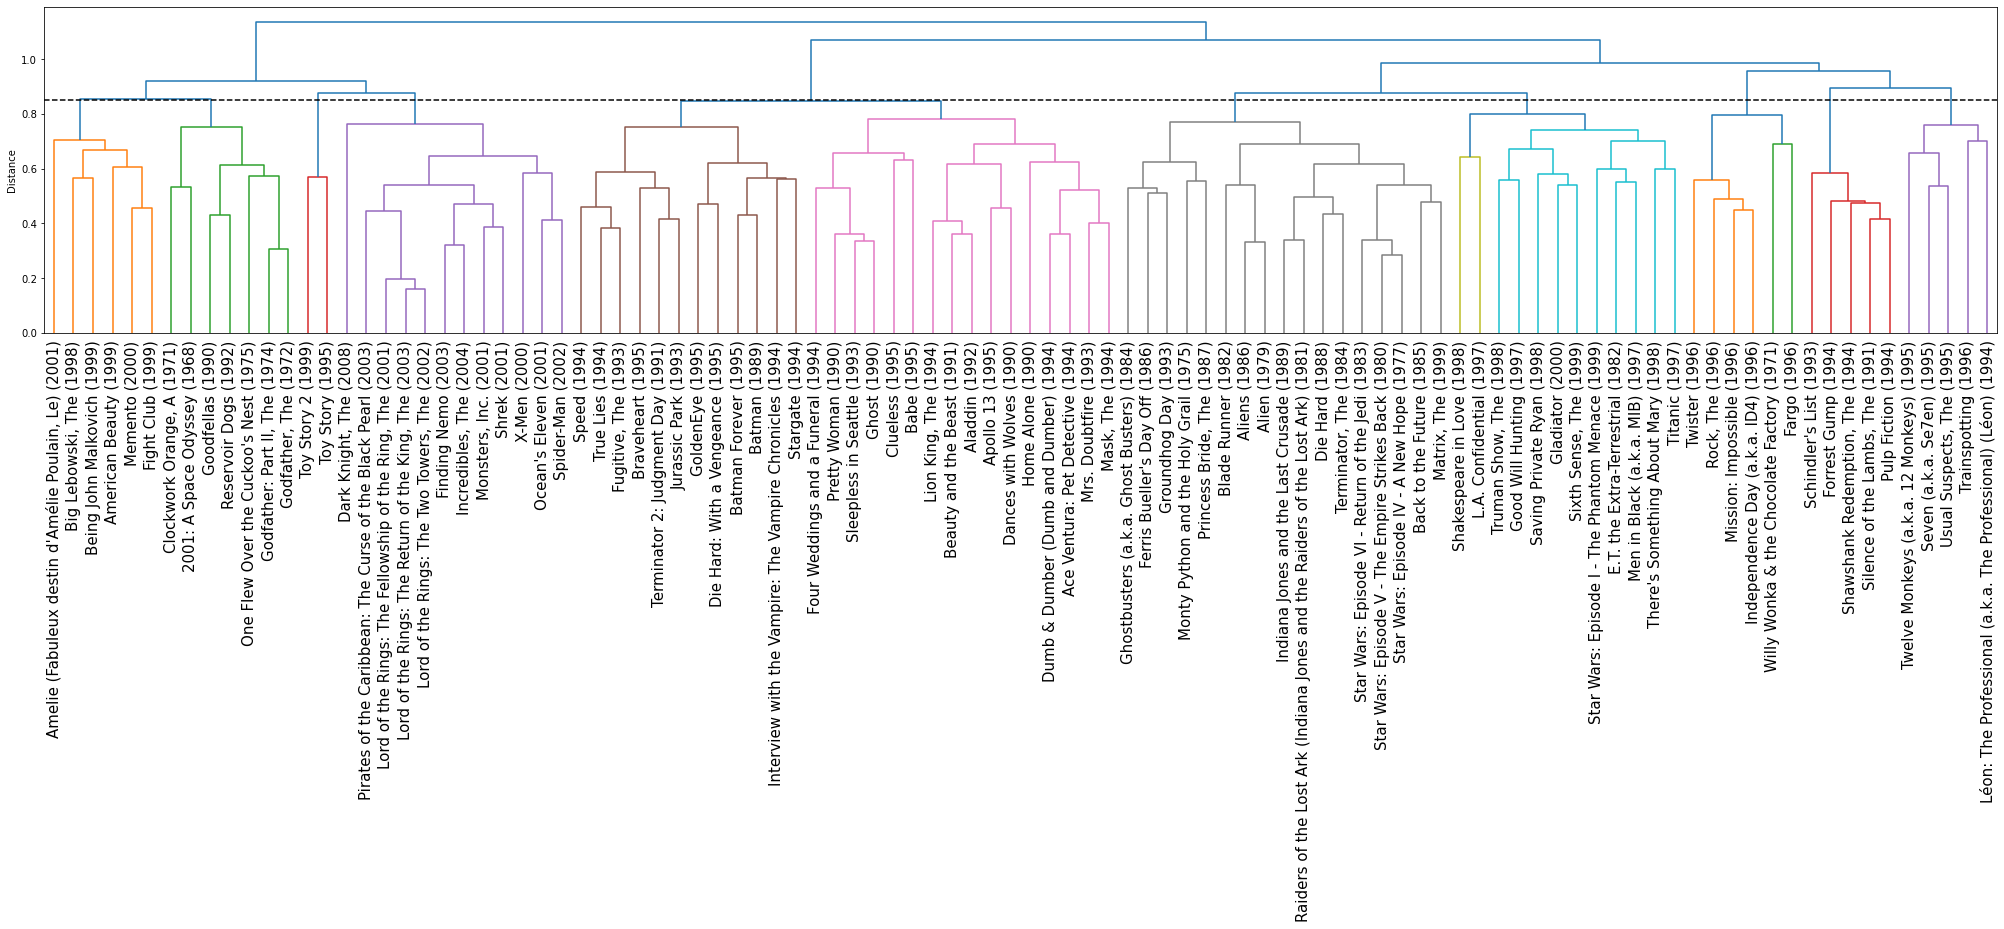

In [29]:

plt.figure(figsize=(35, 6))
D = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.plot([0, 1000], [t, t], "k--")
plt.ylabel("Distance")
plt.show()

#### 2.4. question:

Comment on the validity of the results obtained.

I decided to use the silhoutte score because we don't know how many clusters there are supposed to be. I experimented with multiple values for t when cutting the dendogram (0.6, 0.65, 0.8 and 0.85) and decided to keep 0.85 as I kept getting better results for it.

In [30]:
from sklearn.metrics import silhouette_score

score = silhouette_score(matrix, predictions, metric="cosine")
print(score)

0.12690836286082816
